# Pipeline for High-z Radio Galaxies 12: Application of full pipeline for prediction

## Introduction

In this file, three models will be applied consecutively in order to predict  
the detection of Radio Galaxies (radio AGN) and their redshift.  

In principle, this pipeline should be applied to data in Stripe 82. But  
it can be used with any other suitable dataset.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib import ticker
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
import matplotlib.patches as mpatches
from matplotlib.ticker import ScalarFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.visualization import LogStretch, PowerStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import sklearn.pipeline
import colorcet as cc
from pycaret import classification as pyc
from pycaret import regression as pyr
from pycaret.internal.tabular import _get_columns_to_stratify_by
import pandas as pd
import mpl_scatter_density
# import schemdraw
# from schemdraw import flow

In [2]:
mpl.rcdefaults()

Create path effects.

In [3]:
pe1            = [mpe.Stroke(linewidth=5.0, foreground='black'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]
pe2            = [mpe.Stroke(linewidth=3.0, foreground='white'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]

Define specific metrics for redshift values.

In [4]:
def sigma_mad(z_true, z_pred, **kwargs):
    try:
        med = np.nanmedian(np.abs(z_true - z_pred)).astype('float32')
    except:
        med = np.nanmedian(np.abs(z_true - z_pred))
    return 1.48 * med

In [5]:
def sigma_nmad(z_true, z_pred, **kwargs):
    dif  = (z_true - z_pred)
    frac = dif / (1 + z_true).values
    try:
        med  = np.nanmedian(np.abs(frac)).astype('float32')
    except:
        med  = np.nanmedian(np.abs(frac))
    return 1.48 * med

In [6]:
def sigma_z(z_true, z_pred, **kwargs):
    dif = z_true - z_pred
    ssq = np.sum(dif**2)
    try:
        rot = np.sqrt(ssq / len(z_true)).astype('float32')
    except:
        rot = np.sqrt(ssq / len(z_true))
    return rot

In [7]:
def sigma_z_norm(z_true, z_pred, **kwargs):
    dif = (z_true - z_pred) / (1 + z_true)
    ssq = np.sum(dif**2)
    try:
        rot = np.sqrt(ssq / len(z_true)).astype('float32')
    except:
        rot = np.sqrt(ssq / len(z_true))
    return rot

In [8]:
def outlier_frac(z_true, z_pred, **kwargs):
    dif  = np.abs((z_true - z_pred) / (1 + z_true))
    try:
        siz  = np.sum(np.isfinite(dif)).astype('float32')
        num  = np.sum(np.array(dif > 0.15)).astype('float32')
    except:
        siz  = np.sum(np.isfinite(dif))
        num  = np.sum(np.array(dif > 0.15))
    frac = num / siz
    return frac

Methods for Pycaret and saved models.

In [9]:
def get_final_column_names(pycaret_pipeline, sample_df):
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        for (name, method) in pycaret_pipeline.named_steps.items():
            if method != 'passthrough' and name != 'trained_model':
                print(f'Running {name}')
                sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()
    else:
        try:
            for (name, method) in pyr.get_config('prep_pipe').named_steps.items():
                if method != 'passthrough' and name != 'trained_model':
                    print(f'Running {name}')
                    sample_df = method.transform(sample_df)
        except:
            for (name, method) in pyc.get_config('prep_pipe').named_steps.items():
                if method != 'passthrough' and name != 'trained_model':
                    print(f'Running {name}')
                    sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()

In [10]:
def get_feature_importances_df(pycaret_pipeline, sample_df, n = 10):
    
    final_cols = get_final_column_names(pycaret_pipeline, sample_df)
    
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        try:
            variables = pycaret_pipeline["trained_model"].feature_importances_
            
        except:
            variables = np.mean([
                            tree.feature_importances_ for tree in pycaret_pipeline["trained_model"].estimators_
                if hasattr(tree, 'feature_importances_')
                            ], axis=0)
        
        coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
        sorted_df = (
            coef_df.sort_values(by='Importance', ascending=False)
            .head(n)
            .sort_values(by='Importance', ascending=True).reset_index(drop=True)
        )
    else:
        try:
            variables = pycaret_pipeline.feature_importances_
            
        except:
            variables = np.mean([
                            tree.feature_importances_ for tree in pycaret_pipeline.estimators_
                if hasattr(tree, 'feature_importances_')
                            ], axis=0)
        
        coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
        sorted_df = (
            coef_df.sort_values(by='Importance', ascending=False)
            .head(n)
            .sort_values(by='Importance', ascending=True).reset_index(drop=True)
        )
    return sorted_df

Methods for the use of values in Confusion Matrices.

In [11]:
def flatten_CM(cm_array):
    try:
        TN, FP, FN, TP = cm_array.flatten().astype('float32')
    except:
        TN, FP, FN, TP = cm_array.flatten()
    return TN, FP, FN, TP

In [12]:
def MCC_from_CM(cm_array):  # Matthews correlation coefficient
    TN, FP, FN, TP = flatten_CM(cm_array)
    MCC = ((TP * TN) - (FP * FN)) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
    return MCC

In [13]:
def ACC_from_CM(cm_array):  # Accuracy
    TN, FP, FN, TP = flatten_CM(cm_array)
    ACC = (TP + TN) / (TP + TN + FP + FN)
    return ACC

In [14]:
def F1_from_CM(cm_array):  # F-1 score
    TN, FP, FN, TP = flatten_CM(cm_array)
    F1 = 2 * TP / (2 * TP + FP + FN)
    return F1

In [15]:
def Recall_from_CM(cm_array):  # Recall
    TN, FP, FN, TP = flatten_CM(cm_array)
    Recall = TP / (TP + FN)
    return Recall

Method to plot confusion matrix

In [16]:
def plot_conf_mat(confusion_matrix, title, axin, display_labels=['Non true', 'True'], cmap='cet_dimgray_r', show_clb=False, log_stretch=False):
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=display_labels)

    min_val_colour = np.nanmin(confusion_matrix)
    max_val_colour = np.nanmin(confusion_matrix)
    
    if log_stretch:
        norm = ImageNormalize(stretch=LogStretch())
    if not log_stretch:
        norm = ImageNormalize(stretch=PowerStretch(0.35))

    # NOTE: Fill all variables here with default values of the plot_confusion_matrix
    disp_b = disp.plot(include_values=True, cmap=cm.get_cmap(cmap),\
             ax=axin, xticks_rotation='horizontal', values_format=',')

    for text_val in disp_b.text_.flatten():
        text_val.set_fontsize(28)
    clb = plt.gca().images[-1].colorbar
    clb.ax.tick_params(labelsize=14)
    clb.ax.ticklabel_format(style='sci', scilimits=(0, 0))
    clb.outline.set_linewidth(2.5)
    clb.ax.set_ylabel('Elements in bin', size=14)
    if not show_clb:
        clb.remove()

    # disp_b.im_.set_clim(1e2, 3e3)
    disp_b.im_.norm = norm

    axin.xaxis.get_label().set_fontsize(16)
    axin.yaxis.get_label().set_fontsize(16)

    axin.tick_params(axis='both', which='major', labelsize=14)

    plt.setp(axin.spines.values(), linewidth=2.5)
    plt.setp(axin.spines.values(), linewidth=2.5)
    axin.set_title(title, fontsize=16)
    plt.tight_layout()

Method to plot predicted and true redshift values

In [17]:
def plot_redshift_compare(true_z, predicted_z, ax_pre, title=None, dpi=10, cmap='cet_linear_kryw_5_100_c64_r', show_clb=False, log_stretch=False):
    if log_stretch:
        norm = ImageNormalize(vmin=0., stretch=LogStretch())
    if not log_stretch:
        norm = ImageNormalize(vmin=0., stretch=PowerStretch(0.5))

    filt_pair_z   = np.isfinite(true_z) & np.isfinite(predicted_z)
    max_for_range = np.nanmax([np.nanmax(1 + true_z.loc[filt_pair_z]), np.nanmax(1 + predicted_z.loc[filt_pair_z])])

    dens_1 = ax_pre.scatter_density((1 + true_z.sample(frac=1, random_state=seed)),\
            (1 + predicted_z.sample(frac=1, random_state=seed)),\
            cmap=plt.get_cmap(cmap), zorder=0, dpi=dpi, norm=norm, alpha=0.93)
    
    ax_pre.axline((2., 2.), (3., 3.), ls='--', marker=None, c='Gray', alpha=0.8, lw=3.0, zorder=20)
    ax_pre.axline(xy1=(1., 1.15), xy2=(2., 2.3), ls='-.', marker=None, c='slateblue', alpha=0.6, lw=3.0, zorder=20)
    ax_pre.axline(xy1=(1., 0.85), xy2=(2., 1.7), ls='-.', marker=None, c='slateblue', alpha=0.6, lw=3.0, zorder=20)

    if show_clb:
        clb = plt.colorbar(dens_1, extend='neither', norm=norm, ticks=ticker.MaxNLocator(integer=True))
        clb.ax.tick_params(labelsize=14)
        clb.outline.set_linewidth(2.5)
        clb.ax.set_ylabel('Elements per pixel', size=16, path_effects=pe2)

    # Inset axis with residuals
    axins = inset_axes(ax_pre, width='35%', height='20%', loc=2)
    res_z_z = (predicted_z - true_z) / (1 + true_z)
    axins.hist(res_z_z, histtype='stepfilled', fc='grey', ec='k', bins=50, lw=2.5)
    axins.axvline(x=np.nanpercentile(res_z_z, [15.9]), ls='--', lw=2.5, c='royalblue')
    axins.axvline(x=np.nanpercentile(res_z_z, [84.1]), ls='--', lw=2.5, c='royalblue')
    axins.set_xlabel('$\Delta z / (1 + z_{\mathrm{True}})$', fontsize=10)
    axins.tick_params(labelleft=False, labelbottom=True)
    axins.tick_params(which='both', top=True, right=True, direction='in')
    axins.tick_params(axis='both', which='major', labelsize=10)
    axins.tick_params(which='major', length=8, width=1.5)
    axins.tick_params(which='minor', length=4, width=1.5)
    plt.setp(axins.spines.values(), linewidth=2.5)
    plt.setp(axins.spines.values(), linewidth=2.5)
    axins.set_xlim(left=-0.9, right=0.9)
    ##
    ax_pre.set_xlabel('$1 + z_{\mathrm{True}}$', fontsize=20)
    ax_pre.set_ylabel('$1 + z_{\mathrm{Predicted}}$', fontsize=20)
    ax_pre.tick_params(which='both', top=True, right=True, direction='in')
    ax_pre.tick_params(axis='both', which='minor', labelsize=14)
    ax_pre.tick_params(which='major', length=8, width=1.5)
    ax_pre.tick_params(which='minor', length=4, width=1.5)
    # ax_pre.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    # ax_pre.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax_pre.xaxis.set_minor_formatter(ticker.ScalarFormatter(useMathText=False))
    ax_pre.yaxis.set_minor_formatter(ticker.ScalarFormatter(useMathText=False))
    plt.setp(ax_pre.spines.values(), linewidth=2.5)
    plt.setp(ax_pre.spines.values(), linewidth=2.5)
    ax_pre.set_xlim(left=1., right=np.ceil(max_for_range))
    ax_pre.set_ylim(bottom=1., top=np.ceil(max_for_range))
    ax_pre.set_title(title)
    plt.tight_layout()

---

## Reading data

In [18]:
cat_path            = '../../Catalogs/'  # relative path to the same directory

Flags.

In [19]:
save_plot_flag      = False
load_models_flag    = True
use_zeroth_model    = False  # Initial model to discriminate between star and non-star objects
use_second_z_model  = False  # z >= 2.0
use_third_z_model   = False  # z >= 3.0
use_fourth_z_model  = True  # z >= 3.7 (with SMOGN), or, if needed, z >= 4.0
compare_A17_flag    = True  # Compare with the results from Ananna et al., 2017

In [20]:
used_area           = 'HETDEX'  # can be 'S82', 'HETDEX', 'COSMOS'
use_val_HETDEX      = False  # Use only validation data from HETDEX

In [21]:
if used_area != 'S82':
    compare_A17_flag = False

In [22]:
file_S82            = 'CatWISE2020_S82_VLASS_VLAS82_PS1_GALEX_TGSS_XMM_2MASS_MILLIQUAS_7_4d_ALLWISE_SDSS_DR16_5sigma_imp.h5'
file_HETDEX         = 'CatWISE2020_VLASS_LOFAR_PS1_GALEX_TGSS_XMM_2MASS_MILLIQUAS_7_4d_ALLWISE_LOLSS_SDSS_DR16_5sigma_imp.h5'
file_COSMOS         = 'CatWISE2020_COSMOS_MILLIQUAS_7_4d_COSMOSVLA3_PS1_GALEX_TGSS_VLASS_XMM_2MASS_ALLWISE_SDSS_DR16_5sigma_imp.h5'
file_S82_Ananna_17  = f'CatWISE2020_S82_VLASS_VLAS82_PS1_GALEX_TGSS_XMM_2MASS_MILLIQUAS_7_4d_ALLWISE_Ananna_17_zsp_5sigma_imp.h5'  # 204 objects

file_name_dict      = {'S82': file_S82, 'HETDEX': file_HETDEX, 'COSMOS': file_COSMOS}
file_name           = file_name_dict[used_area]

In [23]:
# feats_2_disc_S82    = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'Total_flux_VLASS',\
#                      'Fint_VLAS82', 'Stotal_TGSS', 'FEP', 'W1mag', 'W2mag']
# feats_2_disc_HETDEX = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'Total_flux_VLASS',\
#                      'Sint_LOFAR', 'Stotal_TGSS', 'FEP', 'TotalFlux_LoLSS', 'W1mag', 'W2mag']
# feats_2_disc_COSMOS = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'Total_flux_VLASS',\
#                      'Stotal_TGSS', 'FEP', 'Flux_COSMOSVLA3', 'W1mag', 'W2mag']

feats_2_disc_S82    = ['RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'W1mag', 'W2mag']
feats_2_disc_HETDEX = ['RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'W1mag', 'W2mag']
feats_2_disc_COSMOS = ['RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'W1mag', 'W2mag']

feats_2_disc        = {'S82': feats_2_disc_S82, 'HETDEX': feats_2_disc_HETDEX, 'COSMOS': feats_2_disc_COSMOS}
features_2_discard  = feats_2_disc[used_area]

In [24]:
full_catalog_df     = pd.read_hdf(cat_path + file_name, key='df').drop(columns=features_2_discard)

In [25]:
full_catalog_df.loc[:, 'radio_detect'] = full_catalog_df.loc[:, 'radio_detect'].astype(int)

Create features with class and combined redshift.

In [26]:
if use_zeroth_model:
    full_catalog_df['is_str'] = np.array(full_catalog_df.loc[:, 'spCl'] == 'STAR  ').astype(int)

In [27]:
full_catalog_df['class']            = full_catalog_df.loc[:, 'is_AGN'].copy()
if use_zeroth_model:
    filter_non_confirmed            = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) |\
                                      np.array(full_catalog_df.loc[:, 'is_gal'] == 1) |\
                                      np.array(full_catalog_df.loc[:, 'is_str'] == 1)
    full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'is_str'] == 1), 'class'] = 2
elif not use_zeroth_model:
    filter_non_confirmed            = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) |\
                                      np.array(full_catalog_df.loc[:, 'is_gal'] == 1)
full_catalog_df.loc[~filter_non_confirmed, 'class'] = 0.5
idx_non_Z                           = full_catalog_df.loc[:, 'Z'].where(full_catalog_df.loc[:, 'Z'] > 0).isna()
full_catalog_df.loc[idx_non_Z, 'Z'] = full_catalog_df.loc[:, 'Z'].mask(idx_non_Z, full_catalog_df.loc[idx_non_Z, 'zsp'])

Create column for detection as Radio AGN

In [28]:
full_catalog_df['radio_AGN']        = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) & np.array(full_catalog_df.loc[:, 'radio_detect'] == 1)

##### Random seed

In [29]:
seed                                = 42

---

Split dataset if from HETDEX

In [30]:
if used_area == 'HETDEX' and use_val_HETDEX:
    full_catalog_df = full_catalog_df.loc[(full_catalog_df.loc[:, 'is_AGN'] == 1) | (full_catalog_df.loc[:, 'is_gal'] == 1)]
    train_test_df, validation_df = train_test_split(full_catalog_df, test_size=0.2, random_state=seed, stratify=full_catalog_df.loc[:, 'class'])
    # data_train_test_AGN_df = full_catalog_df.sample(frac=0.9, random_state=seed)  # Train + test sets
    # data_validation_AGN_df = full_catalog_df.drop(data_train_test_AGN_df.index)  # Validation data
    
    print('Shape of used data')
    print('-' * 40)
    print(f'Full Dataset size: {full_catalog_df.shape}')
    print(f'Data for Modeling (Train and Test): {train_test_df.shape}')
    print(f'Unseen Data For Validation: {validation_df.shape}')
    print('-' * 40)
    full_catalog_df = validation_df

Discard minor features.

In [31]:
full_catalog_df                     = full_catalog_df.drop(columns=['is_AGN', 'is_SDSS_gal', 'is_gal', 'zsp', 'spCl'])

---

### Load models

In [32]:
if load_models_flag:
    if use_zeroth_model:
        star_clf        = pyc.load_model('models/classification_star_no_star_jun_30_2022')  # star/no-star model
    AGN_gal_clf     = pyc.load_model('models/classification_AGN_galaxy_may_15_2022')
    radio_det_clf   = pyc.load_model('models/classification_radio_detect_may_16_2022')
    redshift_reg    = pyr.load_model('models/regression_z_may_17_2022')  # to use on full sample
    if use_second_z_model:
        redshift_reg_2  = pyr.load_model('models/regression_z_may_18_2022')  # to use on sources with predicted z >= 2
    if use_third_z_model:
        redshift_reg_3  = pyr.load_model('models/regression_z_may_30_2022')  # to use on sources with predicted z >= 3
    if use_fourth_z_model:
        # redshift_reg_4  = pyr.load_model('models/regression_z_may_31_2022')  # to use on sources with predicted z >= 3.7 (for z >= 4, regression_z_may_31_4_2022)
        # redshift_reg_4  = pyr.load_model('models/regression_z_may_31_4_2022')  # to use on sources with predicted z >= 3.7 (for z >= 4, regression_z_may_31_4_2022)
        redshift_reg_4  = pyr.load_model('models/regression_z_jun_01_2022')  # to use on sources with predicted z >= 3.7 used with SMOGN

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


In [33]:
if use_zeroth_model:
    threshold_star = 0.37441  # 0.5, 0.15688 from ROC AUC in train+test, 0.37441 from PR curve
threshold_AGN   = 0.31117  # 0.5, 0.3094 from ROC AUC in train+test, 0.31117 from PR curve
threshold_radio = 4.99972232e-01  # 0.5, 4.99972232e-01 from ROC AUC in train+test and PR curve

In [34]:
if use_zeroth_model:  # we want no-star sources => label == 0
    full_catalog_df = pyc.predict_model(star_clf, data=full_catalog_df, probability_threshold=threshold_star, raw_score=True, round=10)
    full_catalog_df = full_catalog_df.drop(columns=['Score_1'])
    full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_star', 'Score_0': 'Score_no_star'})
    full_catalog_df.loc[:, 'Score_no_star'] = np.around(full_catalog_df.loc[:, 'Score_no_star'], decimals=7)
elif not use_zeroth_model:
    full_catalog_df['pred_star']     = 0
    full_catalog_df['Score_no_star'] = 1

In [35]:
full_catalog_df = pyc.predict_model(AGN_gal_clf, data=full_catalog_df, probability_threshold=threshold_AGN, raw_score=True, round=10)
full_catalog_df = full_catalog_df.drop(columns=['Score_0'])
full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_class', 'Score_1': 'Score_AGN'})
full_catalog_df.loc[:, 'Score_AGN'] = np.around(full_catalog_df.loc[:, 'Score_AGN'], decimals=7)

In [36]:
full_catalog_df = pyc.predict_model(radio_det_clf, data=full_catalog_df, probability_threshold=threshold_radio, raw_score=True, round=10)
full_catalog_df = full_catalog_df.drop(columns=['Score_0'])
full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_radio', 'Score_1': 'Score_radio'})
full_catalog_df.loc[:, 'Score_radio'] = np.around(full_catalog_df.loc[:, 'Score_radio'], decimals=7)

In [37]:
full_catalog_df = pyr.predict_model(redshift_reg, data=full_catalog_df, round=10)
full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_Z'})
full_catalog_df.loc[:, 'pred_Z'] = np.around(full_catalog_df.loc[:, 'pred_Z'], decimals=4)

Scores before applying further z models

In [38]:
if use_zeroth_model:
    temp_filt_pred_nstr    = np.array(full_catalog_df.loc[:, 'pred_star'] == 0)  # filter for not being predicted as a star
elif not use_zeroth_model:
    temp_filt_pred_nstr    = np.ones_like(full_catalog_df.loc[:, 'class']).astype(bool)
temp_filt_pred_rAGN        = np.array(full_catalog_df.loc[:, 'pred_class'] == 1) &\
                             np.array(full_catalog_df.loc[:, 'pred_radio'] == 1) &\
                             temp_filt_pred_nstr
sigma_mad_early            = sigma_mad(full_catalog_df.loc[temp_filt_pred_rAGN, 'Z'],    full_catalog_df.loc[temp_filt_pred_rAGN, 'pred_Z'])
sigma_nmad_early           = sigma_nmad(full_catalog_df.loc[temp_filt_pred_rAGN, 'Z'],   full_catalog_df.loc[temp_filt_pred_rAGN, 'pred_Z'])
sigma_z_early              = sigma_z(full_catalog_df.loc[temp_filt_pred_rAGN, 'Z'],      full_catalog_df.loc[temp_filt_pred_rAGN, 'pred_Z'])
sigma_z_norm_early         = sigma_z_norm(full_catalog_df.loc[temp_filt_pred_rAGN, 'Z'], full_catalog_df.loc[temp_filt_pred_rAGN, 'pred_Z'])
out_frac_early             = outlier_frac(full_catalog_df.loc[temp_filt_pred_rAGN, 'Z'], full_catalog_df.loc[temp_filt_pred_rAGN, 'pred_Z'])

In [39]:
temp_z_limit               = 3.7
temp_filt_high_z_rAGN      = temp_filt_pred_rAGN * (full_catalog_df.loc[:, 'pred_Z'] >= temp_z_limit)
sigma_mad_early_hiz        = sigma_mad(full_catalog_df.loc[temp_filt_high_z_rAGN, 'Z'],    full_catalog_df.loc[temp_filt_high_z_rAGN, 'pred_Z'])
sigma_nmad_early_hiz       = sigma_nmad(full_catalog_df.loc[temp_filt_high_z_rAGN, 'Z'],   full_catalog_df.loc[temp_filt_high_z_rAGN, 'pred_Z'])
sigma_z_early_hiz          = sigma_z(full_catalog_df.loc[temp_filt_high_z_rAGN, 'Z'],      full_catalog_df.loc[temp_filt_high_z_rAGN, 'pred_Z'])
sigma_z_norm_early_hiz     = sigma_z_norm(full_catalog_df.loc[temp_filt_high_z_rAGN, 'Z'], full_catalog_df.loc[temp_filt_high_z_rAGN, 'pred_Z'])
out_frac_early_hiz         = outlier_frac(full_catalog_df.loc[temp_filt_high_z_rAGN, 'Z'], full_catalog_df.loc[temp_filt_high_z_rAGN, 'pred_Z'])

In [40]:
redshift_lim_a    = 2.0
redshift_tol_a    = 0.0
redshift_lim_b    = 3.0
redshift_tol_b    = 0.0
redshift_lim_c    = 3.7  # 3.7, 4.0
redshift_tol_c    = 0.0
if use_second_z_model:
    full_catalog_df = pyr.predict_model(redshift_reg_2, data=full_catalog_df, round=10)
    filter_pred_z   = full_catalog_df.loc[:, 'pred_Z'] >= (redshift_lim_a + redshift_tol_a)
    full_catalog_df.loc[:, 'pred_Z'] = full_catalog_df.loc[:, 'pred_Z'].mask(filter_pred_z, full_catalog_df.loc[filter_pred_z, 'Label'])
    full_catalog_df = full_catalog_df.drop(columns=['Label'])
    full_catalog_df.loc[:, 'pred_Z'] = np.around(full_catalog_df.loc[:, 'pred_Z'], decimals=4)
if use_third_z_model:
    full_catalog_df = pyr.predict_model(redshift_reg_3, data=full_catalog_df, round=10)
    filter_pred_z   = full_catalog_df.loc[:, 'pred_Z'] >= (redshift_lim_b + redshift_tol_b)
    full_catalog_df.loc[:, 'pred_Z'] = full_catalog_df.loc[:, 'pred_Z'].mask(filter_pred_z, full_catalog_df.loc[filter_pred_z, 'Label'])
    full_catalog_df = full_catalog_df.drop(columns=['Label'])
    full_catalog_df.loc[:, 'pred_Z'] = np.around(full_catalog_df.loc[:, 'pred_Z'], decimals=4)
if use_fourth_z_model:
    full_catalog_df = pyr.predict_model(redshift_reg_4, data=full_catalog_df, round=10)
    filter_pred_z   = full_catalog_df.loc[:, 'pred_Z'] >= (redshift_lim_c + redshift_tol_c)
    full_catalog_df.loc[:, 'pred_Z'] = full_catalog_df.loc[:, 'pred_Z'].mask(filter_pred_z, full_catalog_df.loc[filter_pred_z, 'Label'])
    full_catalog_df = full_catalog_df.drop(columns=['Label'])
    full_catalog_df.loc[:, 'pred_Z'] = np.around(full_catalog_df.loc[:, 'pred_Z'], decimals=4)

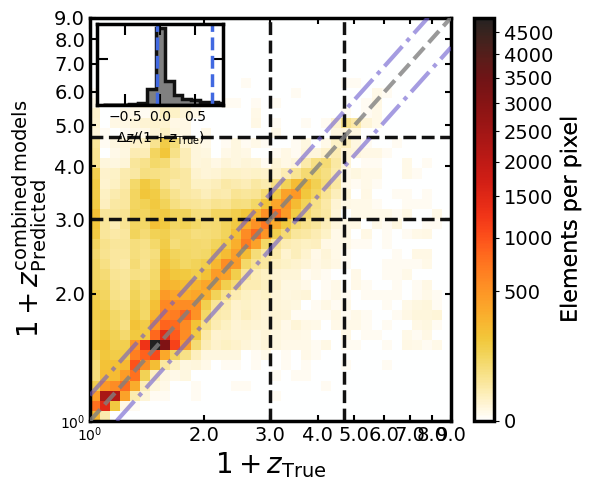

In [41]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
plot_redshift_compare(full_catalog_df.loc[:, 'Z'], full_catalog_df.loc[:, 'pred_Z'], ax_pre=ax1, title=None, dpi=10, show_clb=True, log_stretch=False)
ax1.axvline(x=(1 + redshift_lim_a), ls='--', c='k', lw=2.5)
ax1.axhline(y=(1 + redshift_lim_a), ls='--', c='k', lw=2.5)
ax1.axvline(x=(1 + redshift_lim_c), ls='--', c='k', lw=2.5)
ax1.axhline(y=(1 + redshift_lim_c), ls='--', c='k', lw=2.5)
if use_second_z_model or use_third_z_model or use_fourth_z_model:
    ax1.set_ylabel('$1 + z_{\mathrm{Predicted}}^{\mathrm{combined\,models}}$', size=20)
plt.show()

In [42]:
full_catalog_df['pred_radio_AGN']     = np.array(full_catalog_df.loc[:, 'pred_star']  == 0) &\
                                        np.array(full_catalog_df.loc[:, 'pred_class'] == 1) &\
                                        np.array(full_catalog_df.loc[:, 'pred_radio'] == 1)
full_catalog_df['Score_rAGN']         = full_catalog_df.loc[:, 'Score_no_star'] *\
                                        full_catalog_df.loc[:, 'Score_AGN'] *\
                                        full_catalog_df.loc[:, 'Score_radio']
rad_score_scaler                      = MinMaxScaler()
full_catalog_df['scaled_score_radio'] = rad_score_scaler.fit_transform(full_catalog_df.loc[:, 'Score_radio'].values.reshape(-1, 1))
full_catalog_df['scaled_score_rAGN']  = full_catalog_df.loc[:, 'Score_AGN'] * full_catalog_df.loc[:, 'scaled_score_radio']

In [43]:
displayed_cols = ['is_str', 'pred_star', 'class', 'pred_class', 'radio_detect', 'pred_radio', 'Z', 'pred_Z']
if not use_zeroth_model:
    displayed_cols.remove('is_str')
    displayed_cols.remove('pred_star')
full_catalog_df.loc[:, displayed_cols].describe()

,class,pred_class,radio_detect,pred_radio,Z,pred_Z
count,6.729647e+06,6.729647e+06,6.729647e+06,6.729647e+06,93071.000000,6.729647e+06
mean,4.981605e-01,7.137982e-01,5.133969e-02,2.015479e-01,0.771057,1.879171e+00
std,5.634398e-02,4.519849e-01,2.206897e-01,4.011563e-01,0.754876,6.714378e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-0.004490,4.020000e-02
25%,5.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.257255,1.727900e+00
50%,5.000000e-01,1.000000e+00,0.000000e+00,0.000000e+00,0.550640,2.064400e+00
75%,5.000000e-01,1.000000e+00,0.000000e+00,0.000000e+00,1.003000,2.147900e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,7.028330,5.663000e+00


##### Include AGN detection criteria from literature

In [44]:
full_catalog_df['M12_AGN'] = (np.array(full_catalog_df.loc[:, 'W1mproPM'] - full_catalog_df.loc[:, 'W2mproPM'] - 2.699 + 3.339 <
                                      0.315 * (full_catalog_df.loc[:, 'W2mproPM'] - full_catalog_df.loc[:, 'W3mag'] - 3.339 + 5.174) + 0.791) &
                              np.array(full_catalog_df.loc[:, 'W1mproPM'] - full_catalog_df.loc[:, 'W2mproPM'] - 2.699 + 3.339 >
                                      0.315 * (full_catalog_df.loc[:, 'W2mproPM'] - full_catalog_df.loc[:, 'W3mag'] - 3.339 + 5.174) - 0.222) &
                              np.array(full_catalog_df.loc[:, 'W1mproPM'] - full_catalog_df.loc[:, 'W2mproPM'] - 2.699 + 3.339 >
                                      -3.172 * (full_catalog_df.loc[:, 'W2mproPM'] - full_catalog_df.loc[:, 'W3mag'] - 3.339 + 5.174) + 7.624)).astype(int)

full_catalog_df['S12_AGN'] = np.array(full_catalog_df.loc[:, 'W1mproPM'] - full_catalog_df.loc[:, 'W2mproPM'] - 2.699 + 3.339 >= 0.8).astype(int)

full_catalog_df['M16_AGN'] = (np.array(full_catalog_df.loc[:, 'W1mproPM'] - full_catalog_df.loc[:, 'W2mproPM'] - 2.699 + 3.339 > 0.5) &
                              np.array(full_catalog_df.loc[:, 'W2mproPM'] - full_catalog_df.loc[:, 'W3mag'] - 3.339 + 5.174 < 4.4)).astype(int)

full_catalog_df['B18_AGN'] = (np.array(full_catalog_df.loc[:, 'W1mproPM'] - full_catalog_df.loc[:, 'W2mproPM'] - 2.699 + 3.339 > 0.5) &
                              np.array(full_catalog_df.loc[:, 'W2mproPM'] - full_catalog_df.loc[:, 'W3mag'] - 3.339 + 5.174 > 2.2) &
                              np.array(full_catalog_df.loc[:, 'W1mproPM'] - full_catalog_df.loc[:, 'W2mproPM'] - 2.699 + 3.339 >
                                      2 * (full_catalog_df.loc[:, 'W2mproPM'] - full_catalog_df.loc[:, 'W3mag'] - 3.339 + 5.174) - 8.9)).astype(int)

Obtain intermediate metrics

In [45]:
filter_radio_AGN_t      = np.array(full_catalog_df.loc[:, 'class'] == 1) & np.array(full_catalog_df.loc[:, 'radio_detect'] == 1)
filter_gal_AGN_t        = np.array(full_catalog_df.loc[:, 'class'] == 0) | np.array(full_catalog_df.loc[:, 'class'] == 1)
filter_str_gal_AGN_t    = np.array(full_catalog_df.loc[:, 'class'] == 0) |\
                          np.array(full_catalog_df.loc[:, 'class'] == 1) |\
                          np.array(full_catalog_df.loc[:, 'class'] == 2)
total_size              = len(full_catalog_df)
filter_AGN_t            = np.array(full_catalog_df.loc[:, 'class'] == 1)
num_str_t               = np.sum(np.array(full_catalog_df.loc[:, 'class'] == 2))
num_AGN_t               = np.sum(filter_AGN_t)
num_gal_t               = np.sum(np.array(full_catalog_df.loc[:, 'class'] == 0))
num_str_t               = np.sum(np.array(full_catalog_df.loc[:, 'is_str'] == 1))
num_radio_t             = np.sum(np.array(full_catalog_df.loc[:, 'radio_detect'] == 1))
num_radio_AGN_t         = np.sum(filter_radio_AGN_t)

In [46]:
# filter_radio_AGN_p      = np.array(full_catalog_df.loc[:, 'Score_AGN']          >= threshold_AGN) &\
#                             np.array(full_catalog_df.loc[:, 'Score_radio']      >= threshold_radio)
if use_zeroth_model:
    filter_non_str_p      = np.array(full_catalog_df.loc[:, 'pred_star'] == 0)
elif not use_zeroth_model:
    filter_non_str_p      = np.ones_like(full_catalog_df.loc[:, 'class']).astype(bool)
filter_radio_AGN_p        = full_catalog_df['pred_radio_AGN']
filt_hiz_rAGN_p           = filter_radio_AGN_p * np.array(full_catalog_df.loc[:, 'pred_Z'] >= redshift_lim_c)
filter_AGN_p              = np.array(full_catalog_df.loc[:, 'pred_class'] == 1) & filter_non_str_p
filter_radio_p            = np.array(full_catalog_df.loc[:, 'pred_radio'] == 1)
filt_new_rAGN_p           = filter_radio_AGN_p & np.array(full_catalog_df.loc[:, 'radio_AGN'] == 0)
num_AGN_p                 = np.sum(filter_AGN_p)
num_gal_p                 = np.sum(np.array(full_catalog_df.loc[:, 'pred_class'] == 0) & filter_non_str_p)
num_radio_p               = np.sum(filter_radio_p)
num_radio_AGN_p           = np.sum(filter_radio_AGN_p)
num_rAGN_MQC_p            = np.sum(filter_radio_AGN_p & np.array(full_catalog_df.loc[:, 'class'] == 1))
num_rAGN_gal_p            = np.sum(filter_radio_AGN_p & np.array(full_catalog_df.loc[:, 'class'] == 0))
num_rAGN_str_p            = np.sum(filter_radio_AGN_p & np.array(full_catalog_df.loc[:, 'is_str'] == 1))
num_rAGN_rad_p            = np.sum(filter_radio_AGN_p & np.array(full_catalog_df.loc[:, 'radio_detect'] == 1))
num_new_rAGN_p            = np.sum(filter_radio_AGN_p) - np.sum(filter_radio_AGN_t)

Confusion matrix for Star/not-star classification on confirmed sources (AGN + Galaxies + Stars)

In [47]:
if use_zeroth_model:
    cm_str = np.array([[np.sum(np.array(full_catalog_df.loc[:, 'is_str'] == 0) & np.array(full_catalog_df.loc[:, 'pred_star'] == 0)),\
                        np.sum(np.array(full_catalog_df.loc[:, 'is_str'] == 0) & np.array(full_catalog_df.loc[:, 'pred_star'] == 1))],\
                       [np.sum(np.array(full_catalog_df.loc[:, 'is_str'] == 1) & np.array(full_catalog_df.loc[:, 'pred_star'] == 0)),\
                        np.sum(np.array(full_catalog_df.loc[:, 'is_str'] == 1) & np.array(full_catalog_df.loc[:, 'pred_star'] == 1))]])

Confusion matrix for AGN prediction on confirmed sources (AGN/galaxies). Including initial prediction of not being star.

In [48]:
tmp_filt_AGN = filter_non_str_p * filter_gal_AGN_t
cm_AGN = np.array([[np.sum(np.array(full_catalog_df.loc[tmp_filt_AGN, 'class'] == 0) & np.array(full_catalog_df.loc[tmp_filt_AGN, 'pred_class'] == 0)),\
                    np.sum(np.array(full_catalog_df.loc[tmp_filt_AGN, 'class'] == 0) & np.array(full_catalog_df.loc[tmp_filt_AGN, 'pred_class'] == 1))],\
                   [np.sum(np.array(full_catalog_df.loc[tmp_filt_AGN, 'class'] == 1) & np.array(full_catalog_df.loc[tmp_filt_AGN, 'pred_class'] == 0)),\
                    np.sum(np.array(full_catalog_df.loc[tmp_filt_AGN, 'class'] == 1) & np.array(full_catalog_df.loc[tmp_filt_AGN, 'pred_class'] == 1))]])

Confusion matrix for AGN prediction on all sources (AGN/galaxies + unknown [stars])

In [49]:
cm_AGN_large = np.array([[np.sum(np.array(full_catalog_df.loc[:, 'class'] == 0)    & np.array(full_catalog_df.loc[:, 'pred_class'] == 0) & filter_non_str_p),\
                          np.sum(np.array(full_catalog_df.loc[:, 'class'] == 0)    & np.array(full_catalog_df.loc[:, 'pred_class'] == 0.5)),\
                          np.sum(np.array(full_catalog_df.loc[:, 'class'] == 0)    & np.array(full_catalog_df.loc[:, 'pred_class'] == 1) & filter_non_str_p)],\
                         [np.sum((np.array(full_catalog_df.loc[:, 'class'] == 0.5) | np.array(full_catalog_df.loc[:, 'class'] == 2) | ~filter_non_str_p)     & np.array(full_catalog_df.loc[:, 'pred_class'] == 0)),\
                          np.sum((np.array(full_catalog_df.loc[:, 'class'] == 0.5) | np.array(full_catalog_df.loc[:, 'class'] == 2) | ~filter_non_str_p)     & np.array(full_catalog_df.loc[:, 'pred_class'] == 0.5)),\
                          np.sum((np.array(full_catalog_df.loc[:, 'class'] == 0.5) | np.array(full_catalog_df.loc[:, 'class'] == 2) | ~filter_non_str_p)     & np.array(full_catalog_df.loc[:, 'pred_class'] == 1))],\
                         [np.sum(np.array(full_catalog_df.loc[:, 'class'] == 1)    & np.array(full_catalog_df.loc[:, 'pred_class'] == 0) & filter_non_str_p),\
                          np.sum(np.array(full_catalog_df.loc[:, 'class'] == 1)    & np.array(full_catalog_df.loc[:, 'pred_class'] == 0.5)),\
                          np.sum(np.array(full_catalog_df.loc[:, 'class'] == 1)    & np.array(full_catalog_df.loc[:, 'pred_class'] == 1) & filter_non_str_p)]])

Confusion matrices from literature AGN criteria.

In [50]:
cm_AGN_S12 = np.array([[np.sum(np.array(full_catalog_df.loc[filter_non_str_p, 'class'] == 0) & np.array(full_catalog_df.loc[filter_non_str_p, 'S12_AGN'] == 0)),\
             np.sum(np.array(full_catalog_df.loc[filter_non_str_p, 'class'] == 0) & np.array(full_catalog_df.loc[filter_non_str_p, 'S12_AGN'] == 1))],\
            [np.sum(np.array(full_catalog_df.loc[filter_non_str_p, 'class'] == 1) & np.array(full_catalog_df.loc[filter_non_str_p, 'S12_AGN'] == 0)),\
             np.sum(np.array(full_catalog_df.loc[filter_non_str_p, 'class'] == 1) & np.array(full_catalog_df.loc[filter_non_str_p, 'S12_AGN'] == 1))]])

cm_AGN_M12 = np.array([[np.sum(np.array(full_catalog_df.loc[filter_non_str_p, 'class'] == 0) & np.array(full_catalog_df.loc[filter_non_str_p, 'M12_AGN'] == 0)),\
             np.sum(np.array(full_catalog_df.loc[filter_non_str_p, 'class'] == 0) & np.array(full_catalog_df.loc[filter_non_str_p, 'M12_AGN'] == 1))],\
            [np.sum(np.array(full_catalog_df.loc[filter_non_str_p, 'class'] == 1) & np.array(full_catalog_df.loc[filter_non_str_p, 'M12_AGN'] == 0)),\
             np.sum(np.array(full_catalog_df.loc[filter_non_str_p, 'class'] == 1) & np.array(full_catalog_df.loc[filter_non_str_p, 'M12_AGN'] == 1))]])

cm_AGN_M16 = np.array([[np.sum(np.array(full_catalog_df.loc[filter_non_str_p, 'class'] == 0) & np.array(full_catalog_df.loc[filter_non_str_p, 'M16_AGN'] == 0)),\
             np.sum(np.array(full_catalog_df.loc[filter_non_str_p, 'class'] == 0) & np.array(full_catalog_df.loc[filter_non_str_p, 'M16_AGN'] == 1))],\
            [np.sum(np.array(full_catalog_df.loc[filter_non_str_p, 'class'] == 1) & np.array(full_catalog_df.loc[filter_non_str_p, 'M16_AGN'] == 0)),\
             np.sum(np.array(full_catalog_df.loc[filter_non_str_p, 'class'] == 1) & np.array(full_catalog_df.loc[filter_non_str_p, 'M16_AGN'] == 1))]])

cm_AGN_B18 = np.array([[np.sum(np.array(full_catalog_df.loc[filter_non_str_p, 'class'] == 0) & np.array(full_catalog_df.loc[filter_non_str_p, 'B18_AGN'] == 0)),\
             np.sum(np.array(full_catalog_df.loc[filter_non_str_p, 'class'] == 0) & np.array(full_catalog_df.loc[filter_non_str_p, 'B18_AGN'] == 1))],\
            [np.sum(np.array(full_catalog_df.loc[filter_non_str_p, 'class'] == 1) & np.array(full_catalog_df.loc[filter_non_str_p, 'B18_AGN'] == 0)),\
             np.sum(np.array(full_catalog_df.loc[filter_non_str_p, 'class'] == 1) & np.array(full_catalog_df.loc[filter_non_str_p, 'B18_AGN'] == 1))]])

Confusion matrix for radio detection prediction on all sources (AGN/galaxies + unknown)

In [51]:
cm_radio = np.array([[np.sum(np.array(full_catalog_df.loc[filter_AGN_p, 'radio_detect'] == 0) &\
                             np.array(full_catalog_df.loc[filter_AGN_p, 'pred_radio']   == 0)),\
                      np.sum(np.array(full_catalog_df.loc[filter_AGN_p, 'radio_detect'] == 0) &\
                             np.array(full_catalog_df.loc[filter_AGN_p, 'pred_radio']   == 1))],\
                     [np.sum(np.array(full_catalog_df.loc[filter_AGN_p, 'radio_detect'] == 1) &\
                             np.array(full_catalog_df.loc[filter_AGN_p, 'pred_radio']   == 0)),\
                      np.sum(np.array(full_catalog_df.loc[filter_AGN_p, 'radio_detect'] == 1) &\
                             np.array(full_catalog_df.loc[filter_AGN_p, 'pred_radio']   == 1))]])

Confusion matrix for radio detection prediction on confirmed sources (AGN/galaxies/stars)

In [52]:
cm_radio_conf = np.array([[np.sum(np.array(full_catalog_df.loc[filter_AGN_p & filter_str_gal_AGN_t, 'radio_detect'] == 0) &\
                                  np.array(full_catalog_df.loc[filter_AGN_p & filter_str_gal_AGN_t, 'pred_radio']   == 0)),\
                           np.sum(np.array(full_catalog_df.loc[filter_AGN_p & filter_str_gal_AGN_t, 'radio_detect'] == 0) &\
                                  np.array(full_catalog_df.loc[filter_AGN_p & filter_str_gal_AGN_t, 'pred_radio']   == 1))],\
                          [np.sum(np.array(full_catalog_df.loc[filter_AGN_p & filter_str_gal_AGN_t, 'radio_detect'] == 1) &\
                                  np.array(full_catalog_df.loc[filter_AGN_p & filter_str_gal_AGN_t, 'pred_radio']   == 0)),\
                           np.sum(np.array(full_catalog_df.loc[filter_AGN_p & filter_str_gal_AGN_t, 'radio_detect'] == 1) &\
                                  np.array(full_catalog_df.loc[filter_AGN_p & filter_str_gal_AGN_t, 'pred_radio']   == 1))]])

Confusion matrix for radio AGN prediction on all sources (AGN/galaxies + unknown)

In [53]:
cm_radio_AGN = np.array([[np.sum(np.array(full_catalog_df['radio_AGN'] == 0) & np.array(full_catalog_df['pred_radio_AGN'] == 0)),\
                          np.sum(np.array(full_catalog_df['radio_AGN'] == 0) & np.array(full_catalog_df['pred_radio_AGN'] == 1))],\
                         [np.sum(np.array(full_catalog_df['radio_AGN'] == 1) & np.array(full_catalog_df['pred_radio_AGN'] == 0)),\
                          np.sum(np.array(full_catalog_df['radio_AGN'] == 1) & np.array(full_catalog_df['pred_radio_AGN'] == 1))]])

Confusion matrix for radio AGN prediction on confirmed sources (AGN/galaxies/stars)

In [54]:
cm_radio_AGN_conf = np.array([[np.sum(np.array(full_catalog_df.loc[filter_str_gal_AGN_t, 'radio_AGN'] == 0) &\
                                      np.array(full_catalog_df.loc[filter_str_gal_AGN_t,'pred_radio_AGN'] == 0)),\
                               np.sum(np.array(full_catalog_df.loc[filter_str_gal_AGN_t, 'radio_AGN'] == 0) &\
                                      np.array(full_catalog_df.loc[filter_str_gal_AGN_t,'pred_radio_AGN'] == 1))],\
                              [np.sum(np.array(full_catalog_df.loc[filter_str_gal_AGN_t, 'radio_AGN'] == 1) &\
                                      np.array(full_catalog_df.loc[filter_str_gal_AGN_t,'pred_radio_AGN'] == 0)),\
                               np.sum(np.array(full_catalog_df.loc[filter_str_gal_AGN_t, 'radio_AGN'] == 1) &\
                                      np.array(full_catalog_df.loc[filter_str_gal_AGN_t,'pred_radio_AGN'] == 1))]])

In [55]:
sigma_mad_field            = sigma_mad(full_catalog_df.loc[filter_radio_AGN_p, 'Z'],    full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])
sigma_nmad_field           = sigma_nmad(full_catalog_df.loc[filter_radio_AGN_p, 'Z'],   full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])
sigma_z_field              = sigma_z(full_catalog_df.loc[filter_radio_AGN_p, 'Z'],      full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])
sigma_z_norm_field         = sigma_z_norm(full_catalog_df.loc[filter_radio_AGN_p, 'Z'], full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])
out_frac_field             = outlier_frac(full_catalog_df.loc[filter_radio_AGN_p, 'Z'], full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])

In [56]:
temp_z_limit               = 3.7
filt_high_z_rAGN_p         = filter_radio_AGN_p * (full_catalog_df.loc[:, 'pred_Z'] >= temp_z_limit)
sigma_mad_field_hiz        = sigma_mad(full_catalog_df.loc[filt_high_z_rAGN_p, 'Z'],    full_catalog_df.loc[filt_high_z_rAGN_p, 'pred_Z'])
sigma_nmad_field_hiz       = sigma_nmad(full_catalog_df.loc[filt_high_z_rAGN_p, 'Z'],   full_catalog_df.loc[filt_high_z_rAGN_p, 'pred_Z'])
sigma_z_field_hiz          = sigma_z(full_catalog_df.loc[filt_high_z_rAGN_p, 'Z'],      full_catalog_df.loc[filt_high_z_rAGN_p, 'pred_Z'])
sigma_z_norm_field_hiz     = sigma_z_norm(full_catalog_df.loc[filt_high_z_rAGN_p, 'Z'], full_catalog_df.loc[filt_high_z_rAGN_p, 'pred_Z'])
out_frac_field_hiz         = outlier_frac(full_catalog_df.loc[filt_high_z_rAGN_p, 'Z'], full_catalog_df.loc[filt_high_z_rAGN_p, 'pred_Z'])

Plot histograms for scores.

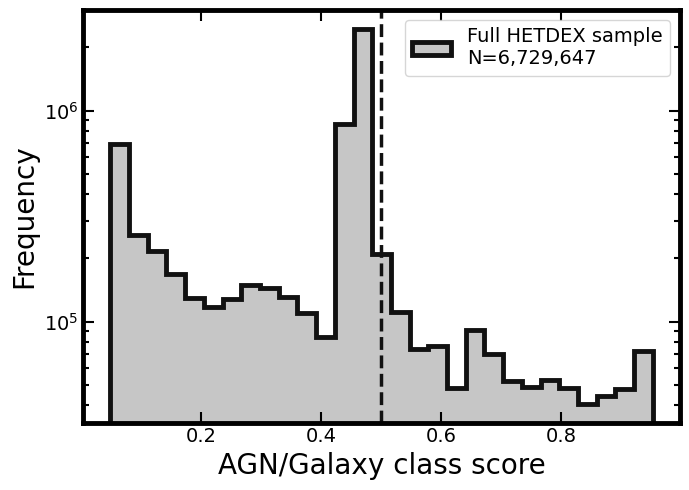

In [57]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score  = np.nanmin(full_catalog_df.loc[:, 'Score_AGN'])
max_score  = np.nanmax(full_catalog_df.loc[:, 'Score_AGN'])
score_bins = np.linspace(min_score, max_score, 30)

sample_size = np.sum(np.isfinite(full_catalog_df.loc[:, 'Score_AGN']))

ax1.hist(full_catalog_df.loc[:, 'Score_AGN'], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=1.0, label=f'Full {used_area} sample\nN={sample_size:,}')

ax1.axvline(x=0.5, ls='--', c='k', lw=2.5)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('AGN/Galaxy class score', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(f'plots/hist_predicted_AGN_scores_{used_area}.pdf', bbox_inches='tight')
plt.show()

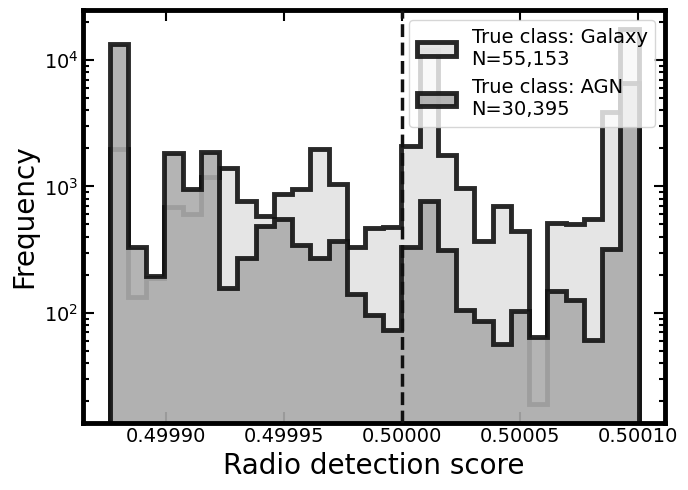

In [58]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(full_catalog_df.loc[:, 'Score_radio'])
max_score       = np.nanmax(full_catalog_df.loc[:, 'Score_radio'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size_gal = np.sum(np.isfinite(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'class'] == 0), 'Score_radio']))
sample_size_AGN = np.sum(np.isfinite(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'class'] == 1), 'Score_radio']))

ax1.hist(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'class'] == 0), 'Score_radio'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.9), alpha=0.9,\
         label=f'True class: Galaxy\nN={sample_size_gal:,}', zorder=np.ceil((sample_size_AGN/sample_size_gal)))
ax1.hist(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'class'] == 1), 'Score_radio'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.7), alpha=0.9,\
         label=f'True class: AGN\nN={sample_size_AGN:,}', zorder=np.ceil((sample_size_gal/sample_size_AGN)))

ax1.axvline(x=0.5, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Radio detection score', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
fig.tight_layout()
#ax1.set_aspect('equal', 'box')
if save_plot_flag:
    plt.savefig(f'plots/hist_predicted_radio_scores_true_class_{used_area}.pdf', bbox_inches='tight')
plt.show()

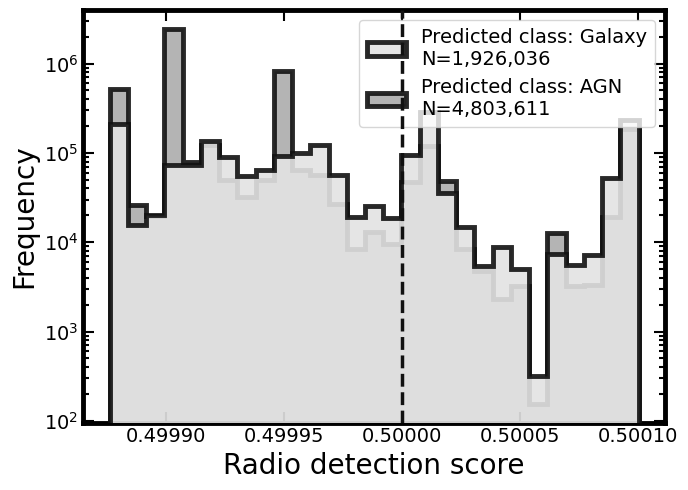

In [59]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(full_catalog_df.loc[:, 'Score_radio'])
max_score       = np.nanmax(full_catalog_df.loc[:, 'Score_radio'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size_gal = np.sum(np.isfinite(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'Score_AGN'] < threshold_AGN), 'Score_radio']))
sample_size_AGN = np.sum(np.isfinite(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'Score_AGN'] >= threshold_AGN), 'Score_radio']))

ax1.hist(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'Score_AGN'] < threshold_AGN), 'Score_radio'],\
         bins=score_bins, histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.9), alpha=0.9,\
         label=f'Predicted class: Galaxy\nN={sample_size_gal:,}', zorder=np.ceil((sample_size_AGN/sample_size_gal)))
ax1.hist(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'Score_AGN'] >= threshold_AGN), 'Score_radio'],\
         bins=score_bins, histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.7), alpha=0.9,\
         label=f'Predicted class: AGN\nN={sample_size_AGN:,}', zorder=np.ceil((sample_size_gal/sample_size_AGN)))

ax1.axvline(x=0.5, ls='--', c='k', lw=2.5, zorder=9)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Radio detection score', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(f'plots/hist_predicted_radio_scores_predicted_class_{used_area}.pdf', bbox_inches='tight')
plt.show()

Plot histograms for predicted and original redshifts.

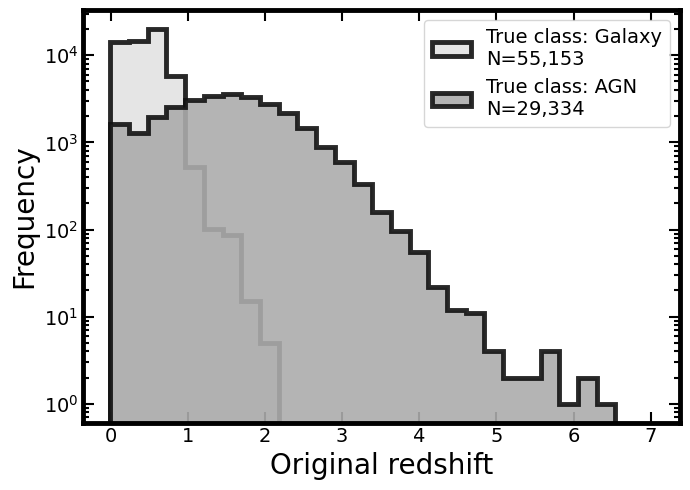

In [60]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(full_catalog_df.loc[:, 'Z'])
max_score       = np.nanmax(full_catalog_df.loc[:, 'Z'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size_gal = np.sum(np.isfinite(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'class'] == 0), 'Z']))
sample_size_AGN = np.sum(np.isfinite(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'class'] == 1), 'Z']))

ax1.hist(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'class'] == 0), 'Z'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.9), alpha=0.9,\
         label=f'True class: Galaxy\nN={sample_size_gal:,}', zorder=np.ceil((sample_size_AGN/sample_size_gal)))
ax1.hist(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'class'] == 1), 'Z'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.7), alpha=0.9,\
         label=f'True class: AGN\nN={sample_size_AGN:,}', zorder=np.ceil((sample_size_gal/sample_size_AGN)))
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Original redshift', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(f'plots/hist_original_redshift_true_class_{used_area}.pdf', bbox_inches='tight')
plt.show()

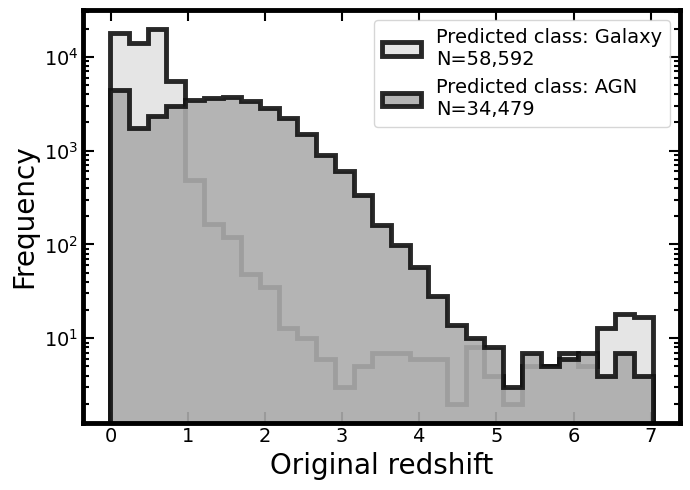

In [61]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(full_catalog_df.loc[:, 'Z'])
max_score       = np.nanmax(full_catalog_df.loc[:, 'Z'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size_gal = np.sum(np.isfinite(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'Score_AGN'] <  threshold_AGN), 'Z']))
sample_size_AGN = np.sum(np.isfinite(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'Score_AGN'] >= threshold_AGN), 'Z']))

ax1.hist(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'Score_AGN'] < threshold_AGN), 'Z'],\
         bins=score_bins, histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.9), alpha=0.9,\
         label=f'Predicted class: Galaxy\nN={sample_size_gal:,}', zorder=np.ceil((sample_size_AGN/sample_size_gal)))
ax1.hist(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'Score_AGN'] >= threshold_AGN), 'Z'],\
         bins=score_bins, histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.7), alpha=0.9,\
         label=f'Predicted class: AGN\nN={sample_size_AGN:,}', zorder=np.ceil((sample_size_gal/sample_size_AGN)))
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Original redshift', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(f'plots/hist_true_redshift_predicted_class_{used_area}.pdf', bbox_inches='tight')
plt.show()

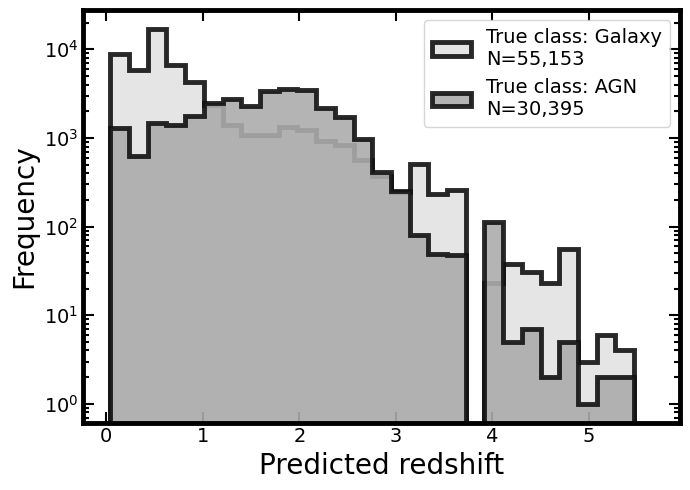

In [62]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(full_catalog_df.loc[:, 'pred_Z'])
max_score       = np.nanmax(full_catalog_df.loc[:, 'pred_Z'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size_gal = np.sum(np.isfinite(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'class'] == 0), 'pred_Z']))
sample_size_AGN = np.sum(np.isfinite(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'class'] == 1), 'pred_Z']))

ax1.hist(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'class'] == 0), 'pred_Z'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.9), alpha=0.9,\
         label=f'True class: Galaxy\nN={sample_size_gal:,}', zorder=np.ceil((sample_size_AGN/sample_size_gal)))
ax1.hist(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'class'] == 1), 'pred_Z'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.7), alpha=0.9,\
         label=f'True class: AGN\nN={sample_size_AGN:,}', zorder=np.ceil((sample_size_gal/sample_size_AGN)))
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Predicted redshift', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(f'plots/hist_predicted_redshift_true_class_{used_area}.pdf', bbox_inches='tight')
plt.show()

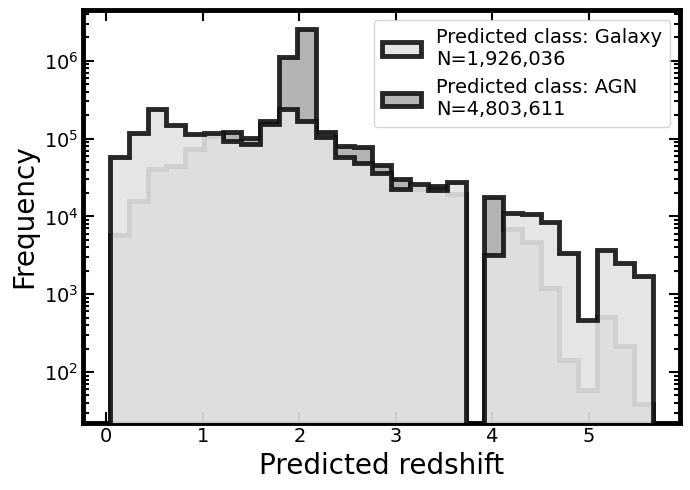

In [63]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(full_catalog_df.loc[:, 'pred_Z'])
max_score       = np.nanmax(full_catalog_df.loc[:, 'pred_Z'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size_gal = np.sum(np.isfinite(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'Score_AGN'] < threshold_AGN), 'pred_Z']))
sample_size_AGN = np.sum(np.isfinite(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'Score_AGN'] >= threshold_AGN), 'pred_Z']))

ax1.hist(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'Score_AGN'] < threshold_AGN), 'pred_Z'],\
         bins=score_bins, histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.9), alpha=0.9,\
         label=f'Predicted class: Galaxy\nN={sample_size_gal:,}', zorder=np.ceil((sample_size_AGN/sample_size_gal)))
ax1.hist(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'Score_AGN'] >= threshold_AGN), 'pred_Z'],\
         bins=score_bins, histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.7), alpha=0.9,\
         label=f'Predicted class: AGN\nN={sample_size_AGN:,}', zorder=np.ceil((sample_size_gal/sample_size_AGN)))
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Predicted redshift', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(f'plots/hist_predicted_redshift_predicted_class_{used_area}.pdf', bbox_inches='tight')
plt.show()

### Select sources predicted to be Radio AGN

In [64]:
displayed_cols = ['is_str', 'pred_star', 'class', 'pred_class', 'radio_detect', 'pred_radio', 'Z', 'pred_Z']
if not use_zeroth_model:
    displayed_cols.remove('is_str')
    displayed_cols.remove('pred_star')
full_catalog_df.loc[filter_radio_AGN_p, displayed_cols].describe()

,class,pred_class,radio_detect,pred_radio,Z,pred_Z
count,504077.000000,504077.0,504077.000000,504077.0,10009.000000,504077.000000
mean,0.508770,1.0,0.184958,1.0,1.166247,1.520312
std,0.069691,0.0,0.388264,0.0,0.901595,0.647876
min,0.000000,1.0,0.000000,1.0,-0.004020,0.040200
25%,0.500000,1.0,0.000000,1.0,0.413000,1.062900
50%,0.500000,1.0,0.000000,1.0,1.047000,1.446000
75%,0.500000,1.0,0.000000,1.0,1.773000,1.921900
max,1.000000,1.0,1.000000,1.0,7.012240,5.523900


Add individual metrics for redshift

In [65]:
full_catalog_df['Delta_z_N'] = np.around((full_catalog_df.loc[:, 'pred_Z'] - full_catalog_df.loc[:, 'Z']) /\
                            (1 + full_catalog_df.loc[:, 'Z']), decimals=3)

full_catalog_df['sigma_NMAD'] = np.around(1.48 * np.abs(full_catalog_df.loc[:, 'pred_Z'] - full_catalog_df.loc[:, 'Z']) /\
                            (1 + full_catalog_df.loc[:, 'Z']), decimals=3)

Numerical summary.

In [66]:
str_0_t    = f'Out of {total_size:,} initial sources in {used_area},\n'
str_1_t    = f'{num_gal_t:,} are confirmed to be galaxies. On the other side,\n'
str_2_t    = f'{num_str_t:,} are listed as SDSS-DR16 stars and {num_AGN_t:,} are MQC AGN.\n'
str_3_t    = f'Also, {num_radio_AGN_t:,} AGN are detected in radio.'

str_0_p    = f'Out of {num_radio_AGN_t:,} initial radio-detected AGN in {used_area},\n'
str_1_p    = f'{num_gal_p:,} are predicted to be galaxies. On the other side,\n'
str_2_p    = f'{num_AGN_p:,} are predicted to be AGN. From the predicted AGN,\n'
str_3_p    = f'{num_radio_AGN_p:,} are predicted to be detected in radio.'

str_0_rAGN = f'{num_radio_AGN_p:,} sources were predicted to be Radio AGN in {used_area}.\n'
str_1_rAGN = f'{num_rAGN_MQC_p:,} of them were listed in MQC.\n'
str_2_rAGN = f'{num_rAGN_gal_p:,} of them are listed as SDSS-DR16 galaxies.\n'
str_3_rAGN = f'{num_rAGN_str_p:,} of them are listed as SDSS-DR16 stars.\n'
str_4_rAGN = f'{num_rAGN_rad_p:,} of them have radio detections.\n'
str_5_rAGN = f'Thus, {num_new_rAGN_p:,} sources are new radio AGN.'

In [67]:
print('-' * 60)
print(str_0_t + str_1_t + str_2_t + str_3_t)
print('-' * 60)
print(str_0_p + str_1_p + str_2_p + str_3_p)
print('-' * 60)
print(str_0_rAGN + str_1_rAGN + str_2_rAGN + str_3_rAGN + str_4_rAGN + str_5_rAGN)
print('-' * 60)

------------------------------------------------------------
Out of 6,729,647 initial sources in HETDEX,
55,153 are confirmed to be galaxies. On the other side,
6,770 are listed as SDSS-DR16 stars and 30,395 are MQC AGN.
Also, 9,894 AGN are detected in radio.
------------------------------------------------------------
Out of 9,894 initial radio-detected AGN in HETDEX,
1,926,037 are predicted to be galaxies. On the other side,
4,803,610 are predicted to be AGN. From the predicted AGN,
504,077 are predicted to be detected in radio.
------------------------------------------------------------
504,077 sources were predicted to be Radio AGN in HETDEX.
9,395 of them were listed in MQC.
553 of them are listed as SDSS-DR16 galaxies.
404 of them are listed as SDSS-DR16 stars.
93,233 of them have radio detections.
Thus, 494,183 sources are new radio AGN.
------------------------------------------------------------


In [68]:
cols_4_table = show_columns = ['Name', 'RA_ICRS', 'DE_ICRS', 'TYPE', 'band_num', 'class', 'pred_class', 'Score_AGN',\
                               'radio_detect', 'pred_radio', 'scaled_score_radio', 'scaled_score_rAGN', 'Z', 'pred_Z']

In [69]:
cols_4_export_S82    = ['Total_flux_VLASS', 'Fint_VLAS82', 'Stotal_TGSS', 'FEP']
cols_4_export_HETDEX = ['Total_flux_VLASS', 'Sint_LOFAR', 'Stotal_TGSS', 'FEP', 'TotalFlux_LoLSS']
cols_4_export_COSMOS = ['Total_flux_VLASS', 'Stotal_TGSS', 'FEP', 'Flux_COSMOSVLA3']

cols_4_exp_all       = {'S82': cols_4_export_S82, 'HETDEX': cols_4_export_HETDEX, 'COSMOS': cols_4_export_COSMOS}

cols_photo           = ['W1mproPM', 'W2mproPM', 'gmag', 'rmag', 'imag', 'zmag', 'ymag', 'FUVmag', 'NUVmag',\
                        'Jmag', 'Hmag', 'Kmag', 'W3mag', 'W4mag']

cols_4_export        = cols_4_table + cols_4_exp_all[used_area] + cols_photo

In [70]:
filter_high_z   = full_catalog_df.loc[:, 'pred_Z']    >= 3.7

In [71]:
display(full_catalog_df.loc[filt_new_rAGN_p * filter_high_z, cols_4_table].sort_values(by=['pred_Z'], ascending=False).head(25))

,Name,RA_ICRS,DE_ICRS,TYPE,band_num,class,pred_class,Score_AGN,radio_detect,pred_radio,scaled_score_radio,scaled_score_rAGN,Z,pred_Z
4948513,J131347.24+544011.3,198.446823,54.669807,,10,0.5,1,0.593318,0,1,0.502676,0.298247,NaN,5.5239
5194516,J130821.47+562035.3,197.089478,56.343147,,10,0.5,1,0.571361,0,1,0.574041,0.327985,NaN,5.4597
4566877,J130322.53+511904.9,195.843857,51.318024,,6,0.5,1,0.441031,0,1,0.485281,0.214024,NaN,5.3044
5124835,J130836.94+554819.5,197.153931,55.805412,,6,0.5,1,0.397967,0,1,0.445138,0.177150,NaN,5.3031
6630523,J123428.46+530827.8,188.618607,53.141064,,6,0.5,1,0.358265,0,1,0.429081,0.153725,NaN,5.2955
825271,J140950.70+534956.9,212.461273,53.832474,,6,0.5,1,0.338421,0,1,0.566459,0.191701,NaN,5.2950
5652540,J124817.93+560335.4,192.074677,56.059826,,6,0.5,1,0.358316,0,1,0.502676,0.180117,NaN,5.2896
3530195,J131844.61+513908.5,199.685852,51.652378,,6,0.5,1,0.327871,0,1,0.436218,0.143023,NaN,5.2840
6473182,J123605.48+523422.4,189.022842,52.572895,,6,0.5,1,0.340046,0,1,0.490633,0.166838,NaN,5.2813
5118355,J121421.77+554218.4,183.590698,55.705112,,6,0.5,1,0.365583,0,1,0.575379,0.210349,NaN,5.2624


In [72]:
display(full_catalog_df.loc[filt_new_rAGN_p * filter_high_z, cols_4_table].sort_values(by=['pred_Z'], ascending=False).head(15))

,Name,RA_ICRS,DE_ICRS,TYPE,band_num,class,pred_class,Score_AGN,radio_detect,pred_radio,scaled_score_radio,scaled_score_rAGN,Z,pred_Z
4948513,J131347.24+544011.3,198.446823,54.669807,,10,0.5,1,0.593318,0,1,0.502676,0.298247,NaN,5.5239
5194516,J130821.47+562035.3,197.089478,56.343147,,10,0.5,1,0.571361,0,1,0.574041,0.327985,NaN,5.4597
4566877,J130322.53+511904.9,195.843857,51.318024,,6,0.5,1,0.441031,0,1,0.485281,0.214024,NaN,5.3044
5124835,J130836.94+554819.5,197.153931,55.805412,,6,0.5,1,0.397967,0,1,0.445138,0.177150,NaN,5.3031
6630523,J123428.46+530827.8,188.618607,53.141064,,6,0.5,1,0.358265,0,1,0.429081,0.153725,NaN,5.2955
825271,J140950.70+534956.9,212.461273,53.832474,,6,0.5,1,0.338421,0,1,0.566459,0.191701,NaN,5.2950
5652540,J124817.93+560335.4,192.074677,56.059826,,6,0.5,1,0.358316,0,1,0.502676,0.180117,NaN,5.2896
3530195,J131844.61+513908.5,199.685852,51.652378,,6,0.5,1,0.327871,0,1,0.436218,0.143023,NaN,5.2840
6473182,J123605.48+523422.4,189.022842,52.572895,,6,0.5,1,0.340046,0,1,0.490633,0.166838,NaN,5.2813
5118355,J121421.77+554218.4,183.590698,55.705112,,6,0.5,1,0.365583,0,1,0.575379,0.210349,NaN,5.2624


In [73]:
display(full_catalog_df.loc[~filt_new_rAGN_p * filter_high_z, cols_4_table].sort_values(by=['Score_AGN', 'pred_Z'], ascending=False).head(15))

,Name,RA_ICRS,DE_ICRS,TYPE,band_num,class,pred_class,Score_AGN,radio_detect,pred_radio,scaled_score_radio,scaled_score_rAGN,Z,pred_Z
4174385,J132345.26+524542.4,200.938629,52.761787,Q,11,1.0,1,0.948873,0,0,0.009813,0.009311,3.656,3.9476
4883063,J141330.37+471749.4,213.376511,47.297062,Q,11,1.0,1,0.947947,1,1,0.982159,0.931034,3.612,3.9476
6608371,J135310.76+482243.3,208.294800,48.378712,Q,11,1.0,1,0.941861,1,1,0.982159,0.925057,3.826,3.9476
5761354,J123556.86+550826.6,188.986923,55.140724,Q,11,1.0,1,0.941440,1,1,0.985727,0.928003,3.669,3.9512
2208040,J112932.92+541854.8,172.387161,54.315216,Q,11,1.0,1,0.940738,0,0,0.173506,0.163223,4.380,3.9476
831122,J110611.60+472434.2,166.548325,47.409500,QR,10,1.0,1,0.940261,1,1,0.722569,0.679404,4.020,3.9518
1984719,J121537.77+545937.3,183.907364,54.993698,Q,11,1.0,1,0.938836,1,1,0.982159,0.922086,4.107,3.9499
4859262,J140916.78+472924.0,212.319946,47.490025,Q,11,1.0,1,0.938675,1,1,0.875558,0.821864,3.652,3.9552
4846431,J131536.58+485629.1,198.902420,48.941429,QR,11,1.0,1,0.937819,1,1,0.982159,0.921087,3.612,3.9476
4828779,J111947.06+462229.3,169.946106,46.374805,Q,11,1.0,1,0.936052,1,1,0.986619,0.923527,3.579,3.9492


In [74]:
display(full_catalog_df.loc[filt_new_rAGN_p * filter_high_z, cols_4_table].sort_values(by=['scaled_score_radio', 'pred_Z'], ascending=False).head(15))

,Name,RA_ICRS,DE_ICRS,TYPE,band_num,class,pred_class,Score_AGN,radio_detect,pred_radio,scaled_score_radio,scaled_score_rAGN,Z,pred_Z
538974,J115913.50+470014.9,179.806259,47.004150,,9,0.5,1,0.440280,1,1,0.995094,0.438120,NaN,4.4855
4157385,J132142.13+544823.3,200.425552,54.806473,,5,0.5,1,0.331344,0,1,0.983497,0.325875,NaN,4.5368
6206893,J133325.28+530702.5,203.355362,53.117374,,6,0.5,1,0.329543,0,1,0.983497,0.324105,NaN,4.5284
2759703,J110541.47+545200.3,166.422775,54.866753,,5,0.5,1,0.345806,0,1,0.981713,0.339483,NaN,4.5254
6677431,J144155.87+490937.4,220.482773,49.160397,,10,0.5,1,0.326461,0,1,0.980821,0.320200,NaN,4.1757
1795588,J134648.50+473401.6,206.702103,47.567127,,9,0.5,1,0.393392,0,1,0.980375,0.385671,NaN,4.1164
6604195,J113234.98+543103.2,173.145737,54.517555,,5,0.5,1,0.339998,0,1,0.978591,0.332719,NaN,4.4035
4777641,J115926.29+494724.9,179.859512,49.790253,,5,0.5,1,0.321864,0,1,0.978591,0.314973,NaN,4.3771
4745475,J140137.35+562547.8,210.405624,56.429943,,5,0.5,1,0.319668,0,1,0.978591,0.312824,NaN,4.3726
3270771,J112618.48+554001.6,171.577026,55.667126,,5,0.5,1,0.339347,0,1,0.945138,0.320730,NaN,4.4392


In [75]:
display(full_catalog_df.loc[filt_new_rAGN_p * filter_high_z, cols_4_table].sort_values(by=['scaled_score_rAGN', 'pred_Z'], ascending=False).head(15))

,Name,RA_ICRS,DE_ICRS,TYPE,band_num,class,pred_class,Score_AGN,radio_detect,pred_radio,scaled_score_radio,scaled_score_rAGN,Z,pred_Z
578385,J141845.28+543407.6,214.688690,54.568794,,11,0.5,1,0.756781,0,1,0.836307,0.632901,NaN,3.9492
5676243,J111444.02+521108.0,168.683426,52.185547,,11,0.5,1,0.929096,1,1,0.601249,0.558618,NaN,3.9503
5967552,J145544.35+533211.6,223.934769,53.536572,,11,0.5,1,0.914142,0,1,0.598127,0.546773,NaN,3.9476
6338787,J145439.57+470741.9,223.664886,47.128338,,11,0.5,1,0.899541,0,1,0.599465,0.539243,NaN,3.9476
5690838,J143232.21+532553.9,218.134201,53.431648,,11,0.5,1,0.915907,0,1,0.580731,0.531896,NaN,3.9499
5104783,J143513.12+462651.2,218.804672,46.447559,,11,0.5,1,0.872846,0,1,0.596789,0.520905,NaN,3.9530
5589809,J143612.87+524238.1,219.053619,52.710594,,11,0.5,1,0.726643,0,1,0.695361,0.505280,NaN,3.9492
6415492,J143413.03+545329.3,218.554306,54.891491,,11,0.5,1,0.843104,1,1,0.598127,0.504283,NaN,4.0430
6336407,J114811.78+543808.4,177.049072,54.635658,,10,0.5,1,0.831932,0,1,0.599465,0.498714,NaN,4.1717
4956713,J120205.68+474814.5,180.523621,47.804020,,9,0.5,1,0.776084,0,1,0.641838,0.498120,NaN,3.9556


In [76]:
display(full_catalog_df.loc[filter_high_z, cols_4_table].sort_values(by=['scaled_score_rAGN', 'pred_Z'], ascending=False).head(15))

,Name,RA_ICRS,DE_ICRS,TYPE,band_num,class,pred_class,Score_AGN,radio_detect,pred_radio,scaled_score_radio,scaled_score_rAGN,Z,pred_Z
4883063,J141330.37+471749.4,213.376511,47.297062,Q,11,1.0,1,0.947947,1,1,0.982159,0.931034,3.612,3.9476
5761354,J123556.86+550826.6,188.986923,55.140724,Q,11,1.0,1,0.941440,1,1,0.985727,0.928003,3.669,3.9512
6608371,J135310.76+482243.3,208.294800,48.378712,Q,11,1.0,1,0.941861,1,1,0.982159,0.925057,3.826,3.9476
4828779,J111947.06+462229.3,169.946106,46.374805,Q,11,1.0,1,0.936052,1,1,0.986619,0.923527,3.579,3.9492
1984719,J121537.77+545937.3,183.907364,54.993698,Q,11,1.0,1,0.938836,1,1,0.982159,0.922086,4.107,3.9499
4846431,J131536.58+485629.1,198.902420,48.941429,QR,11,1.0,1,0.937819,1,1,0.982159,0.921087,3.612,3.9476
4836323,J143440.80+475826.4,218.669998,47.974003,Q,11,1.0,1,0.928947,1,1,0.989295,0.919003,3.666,3.9515
4836087,J135404.72+460724.8,208.519653,46.123558,Q,11,1.0,1,0.924757,1,1,0.990187,0.915682,3.833,3.9492
4882403,J113738.75+501142.4,174.411453,50.195126,Q,11,1.0,1,0.928987,1,1,0.983943,0.914070,3.994,3.9499
4836334,J134515.76+514242.3,206.315628,51.711754,Q,11,1.0,1,0.923174,1,1,0.982159,0.906704,3.632,3.9476


Confusion matrix for AGN/galaxy prediction on all sources

In [77]:
MCC_AGN              = MCC_from_CM(cm_AGN)
ACC_AGN              = ACC_from_CM(cm_AGN)
F1_AGN               = F1_from_CM(cm_AGN)
Recall_AGN           = Recall_from_CM(cm_AGN)

Confusion matrices for AGN criteria from literature

In [78]:
MCC_AGN_S12          = MCC_from_CM(cm_AGN_S12)
ACC_AGN_S12          = ACC_from_CM(cm_AGN_S12)
F1_AGN_S12           = F1_from_CM(cm_AGN_S12)
Recall_AGN_S12       = Recall_from_CM(cm_AGN_S12)

MCC_AGN_M12          = MCC_from_CM(cm_AGN_M12)
ACC_AGN_M12          = ACC_from_CM(cm_AGN_M12)
F1_AGN_M12           = F1_from_CM(cm_AGN_M12)
Recall_AGN_M12       = Recall_from_CM(cm_AGN_M12)

MCC_AGN_M16          = MCC_from_CM(cm_AGN_M16)
ACC_AGN_M16          = ACC_from_CM(cm_AGN_M16)
F1_AGN_M16           = F1_from_CM(cm_AGN_M16)
Recall_AGN_M16       = Recall_from_CM(cm_AGN_M16)

MCC_AGN_B18          = MCC_from_CM(cm_AGN_B18)
ACC_AGN_B18          = ACC_from_CM(cm_AGN_B18)
F1_AGN_B18           = F1_from_CM(cm_AGN_B18)
Recall_AGN_B18       = Recall_from_CM(cm_AGN_B18)

Confusion matrix for radio detection prediction on all predicted AGN

In [79]:
MCC_radio            = MCC_from_CM(cm_radio)
ACC_radio            = ACC_from_CM(cm_radio)
F1_radio             = F1_from_CM(cm_radio)
Recall_radio         = Recall_from_CM(cm_radio)

Confusion matrix for radio detection prediction on all confirmed sources

In [80]:
MCC_radio_conf       = MCC_from_CM(cm_radio_conf)
ACC_radio_conf       = ACC_from_CM(cm_radio_conf)
F1_radio_conf        = F1_from_CM(cm_radio_conf)
Recall_radio_conf    = Recall_from_CM(cm_radio_conf)

Confusion matrix for radio AGN detection prediction.

In [81]:
MCC_radio_AGN        = MCC_from_CM(cm_radio_AGN)
ACC_radio_AGN        = ACC_from_CM(cm_radio_AGN)
F1_radio_AGN         = F1_from_CM(cm_radio_AGN)
Recall_radio_AGN     = Recall_from_CM(cm_radio_AGN)

Confusion matrix for radio AGN detection prediction on confirmed sources.

In [82]:
MCC_radio_AGN_conf    = MCC_from_CM(cm_radio_AGN_conf)
ACC_radio_AGN_conf    = ACC_from_CM(cm_radio_AGN_conf)
F1_radio_AGN_conf     = F1_from_CM(cm_radio_AGN_conf)
Recall_radio_AGN_conf = Recall_from_CM(cm_radio_AGN_conf)

Print metrics

In [83]:
print('Metrics for AGN prediction on all spectroscopically confirmed sources.')
print(f'Sample size,                        N = {np.sum(filter_gal_AGN_t):,}')
print(f'Matthews Correlation Coefficient, MCC = {MCC_AGN:.4f}')
print(f'Accuracy,                         ACC = {ACC_AGN:.4f}')
print(f'F-1 Score,                         F1 = {F1_AGN:.4f}')
print(f'Recall,                        Recall = {Recall_AGN:.4f}')

Metrics for AGN prediction on all spectroscopically confirmed sources.
Sample size,                        N = 85,548
Matthews Correlation Coefficient, MCC = 0.9424
Accuracy,                         ACC = 0.9729
F-1 Score,                         F1 = 0.9629
Recall,                        Recall = 0.9885


In [84]:
print('Metrics for AGN detection criteria (from literature) on all spectroscopically confirmed sources.')
print(f'Sample size, N = {np.sum(filter_gal_AGN_t):,}')
print('Criterion:        S12\tM12\tM16\tMB18')
print(f'MCC,       MCC = {MCC_AGN_S12:.4f}\t{MCC_AGN_M12:.4f}\t{MCC_AGN_M16:.4f}\t{MCC_AGN_B18:.4f}')
print(f'Accuracy,  ACC = {ACC_AGN_S12:.4f}\t{ACC_AGN_M12:.4f}\t{ACC_AGN_M16:.4f}\t{ACC_AGN_B18:.4f}')
print(f'F-1 Score,  F1 = {F1_AGN_S12:.4f}\t{F1_AGN_M12:.4f}\t{F1_AGN_M16:.4f}\t{F1_AGN_B18:.4f}')
print(f'Recall, Recall = {Recall_AGN_S12:.4f}\t{Recall_AGN_M12:.4f}\t{Recall_AGN_M16:.4f}\t{Recall_AGN_B18:.4f}')

Metrics for AGN detection criteria (from literature) on all spectroscopically confirmed sources.
Sample size, N = 85,548
Criterion:        S12	M12	M16	MB18
MCC,       MCC = 0.7057	0.5123	0.6287	0.7438
Accuracy,  ACC = 0.8673	0.7720	0.8273	0.8816
F-1 Score,  F1 = 0.8027	0.5305	0.6879	0.8074
Recall, Recall = 0.7600	0.3624	0.5358	0.6981


In [85]:
print('Metrics for radio detection prediction on all predicted AGN')
print(f'Sample size,                        N = {np.sum(filter_AGN_p):,}')
print(f'Matthews Correlation Coefficient, MCC = {MCC_radio:.4f}')
print(f'Accuracy,                         ACC = {ACC_radio:.4f}')
print(f'F-1 Score,                         F1 = {F1_radio:.4f}')
print(f'Recall,                        Recall = {Recall_radio:.4f}')

Metrics for radio detection prediction on all predicted AGN
Sample size,                        N = 4,803,610
Matthews Correlation Coefficient, MCC = 0.2473
Accuracy,                         ACC = 0.8926
F-1 Score,                         F1 = 0.2655
Recall,                        Recall = 0.4702


In [86]:
print('Metrics for radio detection prediction on all confirmed sources predicted to be AGN')
print(f'Sample size,                        N = {np.sum(filter_AGN_p & filter_gal_AGN_t):,}')
print(f'Matthews Correlation Coefficient, MCC = {MCC_radio_conf:.4f}')
print(f'Accuracy,                         ACC = {ACC_radio_conf:.4f}')
print(f'F-1 Score,                         F1 = {F1_radio_conf:.4f}')
print(f'Recall,                        Recall = {Recall_radio_conf:.4f}')

Metrics for radio detection prediction on all confirmed sources predicted to be AGN
Sample size,                        N = 32,008
Matthews Correlation Coefficient, MCC = 0.8661
Accuracy,                         ACC = 0.9422
F-1 Score,                         F1 = 0.9081
Recall,                        Recall = 0.8978


In [87]:
print('Metrics for radio AGN detection prediction')
print(f'Sample size,                        N = {total_size:,}')
print(f'Matthews Correlation Coefficient, MCC = {MCC_radio_AGN:.4f}')
print(f'Accuracy,                         ACC = {ACC_radio_AGN:.4f}')
print(f'F-1 Score,                         F1 = {F1_radio_AGN:.4f}')
print(f'Recall,                        Recall = {Recall_radio_AGN:.4f}')

Metrics for radio AGN detection prediction
Sample size,                        N = 6,729,647
Matthews Correlation Coefficient, MCC = 0.1181
Accuracy,                         ACC = 0.9262
F-1 Score,                         F1 = 0.0341
Recall,                        Recall = 0.8851


In [88]:
print('Metrics for radio AGN detection prediction on all confirmed sources')
print(f'Sample size,                        N = {np.sum(filter_gal_AGN_t):,}')
print(f'Matthews Correlation Coefficient, MCC = {MCC_radio_AGN_conf:.4f}')
print(f'Accuracy,                         ACC = {ACC_radio_AGN_conf:.4f}')
print(f'F-1 Score,                         F1 = {F1_radio_AGN_conf:.4f}')
print(f'Recall,                        Recall = {Recall_radio_AGN_conf:.4f}')

Metrics for radio AGN detection prediction on all confirmed sources
Sample size,                        N = 85,548
Matthews Correlation Coefficient, MCC = 0.8673
Accuracy,                         ACC = 0.9728
F-1 Score,                         F1 = 0.8827
Recall,                        Recall = 0.8851


In [89]:
print('Metrics for redshift prediction on all predicted radio AGN with only one Z model')
print(f'Sample size,                        N = {np.sum(np.isfinite(full_catalog_df.loc[:, "Z"]) & np.isfinite(full_catalog_df.loc[:, "pred_Z"])):,}')
print(f'Sigma MAD                       \u03C3 MAD = {sigma_mad_early:.4f}')
print(f'Sigma NMAD,                    \u03C3 NMAD = {sigma_nmad_early:.4f}')
print(f'Sigma z,                          \u03C3 z = {sigma_z_early:.4f}')
print(f'Sigma z normalized,             \u03C3 z N = {sigma_z_norm_early:.4f}')
print(f'Outlier fraction,                   \u03B7 = {out_frac_early:.4f}')

Metrics for redshift prediction on all predicted radio AGN with only one Z model
Sample size,                        N = 93,071
Sigma MAD                       σ MAD = 0.1104
Sigma NMAD,                    σ NMAD = 0.0529
Sigma z,                          σ z = 0.0752
Sigma z normalized,             σ z N = 0.0586
Outlier fraction,                   η = 0.1599


In [90]:
print('Metrics for redshift prediction on all predicted radio AGN with all models')
print(f'Sample size,                        N = {np.sum(np.isfinite(full_catalog_df.loc[:, "Z"]) & np.isfinite(full_catalog_df.loc[:, "pred_Z"])):,}')
print(f'Sigma MAD                       \u03C3 MAD = {sigma_mad_field:.4f}')
print(f'Sigma NMAD,                    \u03C3 NMAD = {sigma_nmad_field:.4f}')
print(f'Sigma z,                          \u03C3 z = {sigma_z_field:.4f}')
print(f'Sigma z normalized,             \u03C3 z N = {sigma_z_norm_field:.4f}')
print(f'Outlier fraction,                   \u03B7 = {out_frac_field:.4f}')

Metrics for redshift prediction on all predicted radio AGN with all models
Sample size,                        N = 93,071
Sigma MAD                       σ MAD = 0.1104
Sigma NMAD,                    σ NMAD = 0.0528
Sigma z,                          σ z = 0.0755
Sigma z normalized,             σ z N = 0.0590
Outlier fraction,                   η = 0.1597


In [91]:
print('Metrics for redshift prediction on predicted radio AGN with only one Z model at high z (original prediction)')
print(f'Sample size,                        N = {np.sum(np.isfinite(full_catalog_df.loc[:, "Z"]) & np.isfinite(full_catalog_df.loc[:, "pred_Z"]) & np.array(full_catalog_df.loc[:, "pred_Z"] >= redshift_lim_c)):,}')
print(f'Sigma MAD                       \u03C3 MAD = {sigma_mad_early_hiz:.4f}')
print(f'Sigma NMAD,                    \u03C3 NMAD = {sigma_nmad_early_hiz:.4f}')
print(f'Sigma z,                          \u03C3 z = {sigma_z_early_hiz:.4f}')
print(f'Sigma z normalized,             \u03C3 z N = {sigma_z_norm_early_hiz:.4f}')
print(f'Outlier fraction,                   \u03B7 = {out_frac_early_hiz:.4f}')

Metrics for redshift prediction on predicted radio AGN with only one Z model at high z (original prediction)
Sample size,                        N = 394
Sigma MAD                       σ MAD = 0.3271
Sigma NMAD,                    σ NMAD = 0.0701
Sigma z,                          σ z = 0.2259
Sigma z normalized,             σ z N = 0.2164
Outlier fraction,                   η = 0.1695


In [92]:
print('Metrics for redshift prediction on predicted radio AGN with all models at high z')
print(f'Sample size,                        N = {np.sum(np.isfinite(full_catalog_df.loc[:, "Z"]) & np.isfinite(full_catalog_df.loc[:, "pred_Z"]) & np.array(full_catalog_df.loc[:, "pred_Z"] >= redshift_lim_c)):,}')
print(f'Sigma MAD                       \u03C3 MAD = {sigma_mad_field_hiz:.4f}')
print(f'Sigma NMAD,                    \u03C3 NMAD = {sigma_nmad_field_hiz:.4f}')
print(f'Sigma z,                          \u03C3 z = {sigma_z_field_hiz:.4f}')
print(f'Sigma z normalized,             \u03C3 z N = {sigma_z_norm_field_hiz:.4f}')
print(f'Outlier fraction,                   \u03B7 = {out_frac_field_hiz:.4f}')

Metrics for redshift prediction on predicted radio AGN with all models at high z
Sample size,                        N = 394
Sigma MAD                       σ MAD = 0.2628
Sigma NMAD,                    σ NMAD = 0.0551
Sigma z,                          σ z = 0.2465
Sigma z normalized,             σ z N = 0.2379
Outlier fraction,                   η = 0.1356


Plot predictions

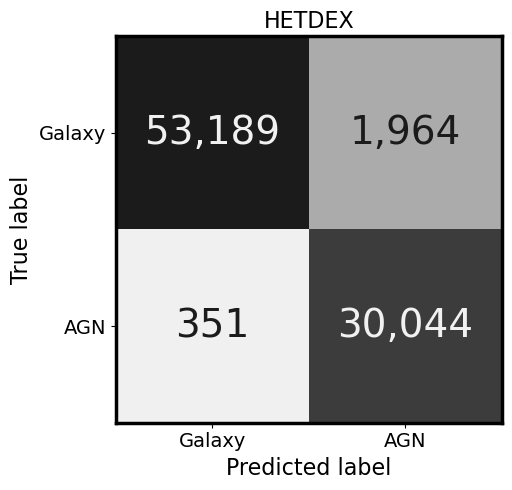

In [93]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
plot_conf_mat(cm_AGN, title=used_area, axin=ax1, display_labels=['Galaxy', 'AGN'], log_stretch=False)
if save_plot_flag:
    plt.savefig(f'plots/conf_matrix_AGN_{used_area}.pdf', bbox_inches='tight')
plt.show()

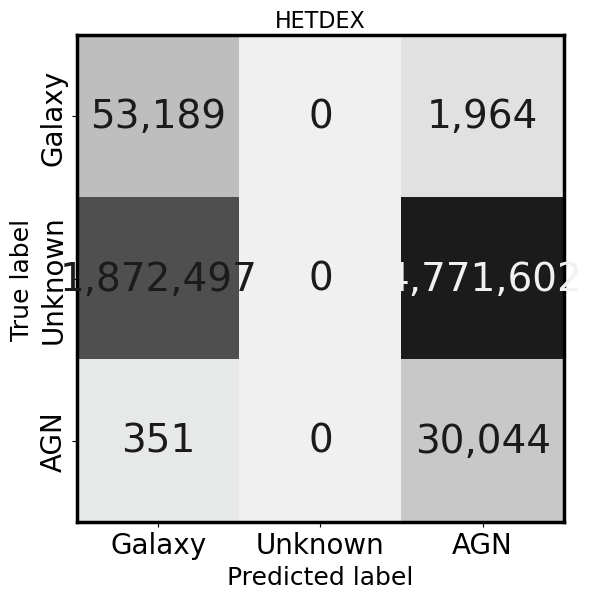

In [94]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)
plot_conf_mat(cm_AGN_large, title=used_area, axin=ax1, display_labels=['Galaxy', 'Unknown', 'AGN'], log_stretch=False)

ax1.xaxis.get_label().set_fontsize(18)
ax1.yaxis.get_label().set_fontsize(18)

ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.tick_params(axis='y', which='major', labelrotation=90)
plt.yticks(va='center')
if save_plot_flag:
    plt.savefig(f'plots/conf_matrix_AGN_all_classes_{used_area}.pdf', bbox_inches='tight')
plt.show()

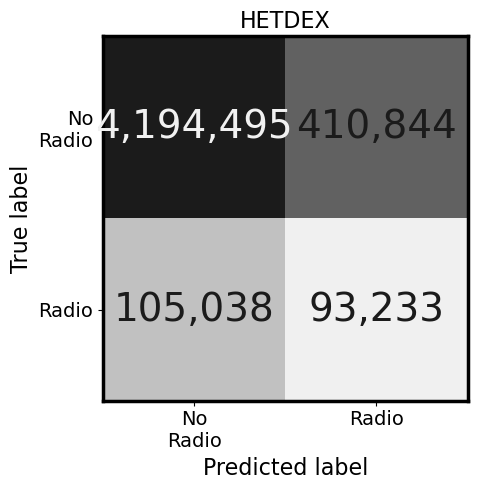

In [95]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
plot_conf_mat(cm_radio, title=used_area, axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=True)
if save_plot_flag:
    plt.savefig(f'plots/conf_matrix_radio_{used_area}.pdf', bbox_inches='tight')
plt.show()

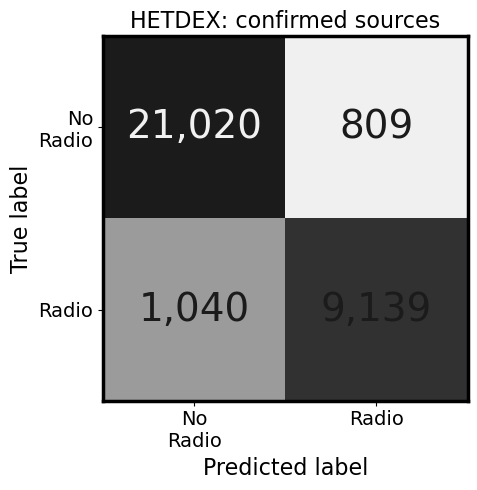

In [96]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
plot_conf_mat(cm_radio_conf, title=used_area+': confirmed sources', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=True)
if save_plot_flag:
    plt.savefig(f'plots/conf_matrix_radio_confirmed_{used_area}.pdf', bbox_inches='tight')
plt.show()

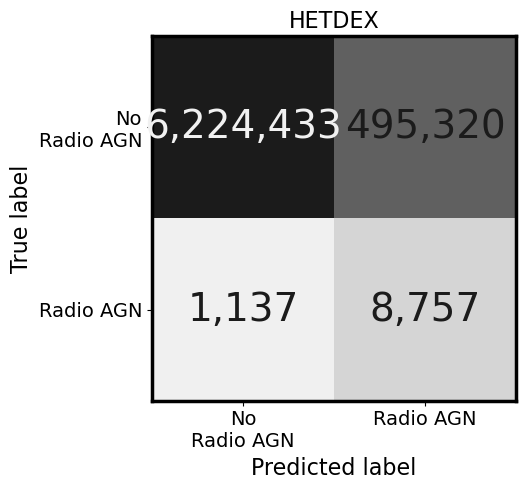

In [97]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
plot_conf_mat(cm_radio_AGN, title=used_area, axin=ax1, display_labels=['No\nRadio AGN', 'Radio AGN'], log_stretch=True)
if save_plot_flag:
    plt.savefig(f'plots/conf_matrix_radio_AGN_{used_area}.pdf', bbox_inches='tight')
plt.show()

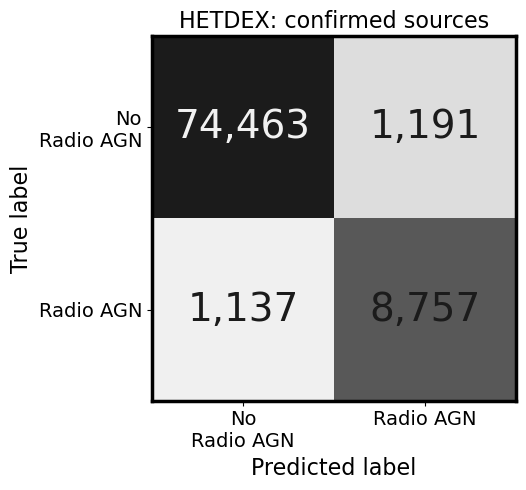

In [98]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
plot_conf_mat(cm_radio_AGN_conf, title=used_area + ': confirmed sources', axin=ax1, display_labels=['No\nRadio AGN', 'Radio AGN'], log_stretch=True)
if save_plot_flag:
    plt.savefig(f'plots/conf_matrix_radio_AGN_confirmed_{used_area}.pdf', bbox_inches='tight')
plt.show()

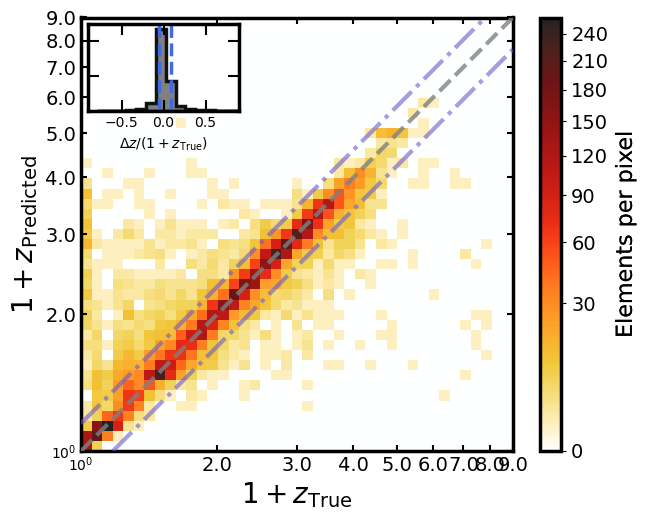

In [99]:
fig             = plt.figure(figsize=(6.8,5.3))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
plot_redshift_compare(full_catalog_df.loc[filter_radio_AGN_p, 'Z'], full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'],\
                      ax_pre=ax1, title=None, dpi=10, show_clb=True, log_stretch=False)
if save_plot_flag:
    plt.savefig(f'plots/compare_redshift_{used_area}.pdf', bbox_inches='tight')
plt.show()

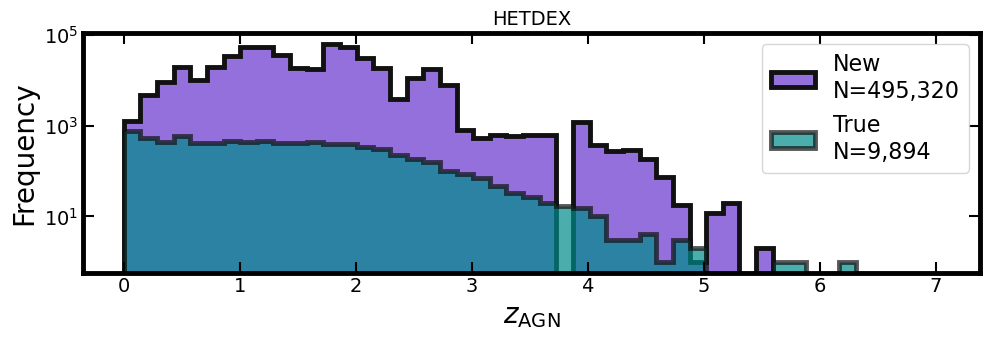

In [100]:
fig             = plt.figure(figsize=(10,3.5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_for_range = np.nanmin([np.nanmin(full_catalog_df.loc[:, 'Z']),\
                           np.nanmin(full_catalog_df.loc[:, 'pred_Z'])])
max_for_range = np.nanmax([np.nanmax(full_catalog_df.loc[:, 'Z']),\
                           np.nanmax(full_catalog_df.loc[:, 'pred_Z'])])
bins_z        = np.linspace(min_for_range, max_for_range, 50)



_, bins, _ = ax1.hist(full_catalog_df.loc[filt_new_rAGN_p, 'pred_Z'], bins=bins_z, histtype='stepfilled',\
                      ec='k', fc='mediumpurple', lw=3.5,\
                      label=f"New\nN={np.sum(filt_new_rAGN_p):,}")
ax1.hist(full_catalog_df.loc[filter_radio_AGN_t * filter_radio_AGN_p, 'Z'], bins=bins_z, histtype='stepfilled', ec='k',\
         fc='darkcyan', lw=3.5, label=f"True\nN={np.sum(filter_radio_AGN_t):,}", alpha=0.7)

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
# ax1.set_xlabel('$m_{\mathrm{W1}}\, \mathrm{[AB]}$', size=20)
ax1.set_xlabel('$z_{\mathrm{AGN}}$', size=20)
ax1.set_ylabel('Frequency', size=20)
# ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=16)
# ax1.invert_xaxis()
# ax1.set_xlim(left=-4, right=6)
#ax1.set_aspect('equal', 'box')
ax1.set_title(used_area, fontsize=14)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(f'plots/hist_true_predicted_z_{used_area}.pdf')
plt.show()

---

## Additional test with data from Ananna et al., 2017

In [101]:
if compare_A17_flag:
    full_catalog_A17_df = pd.read_hdf(cat_path + file_S82_Ananna_17, key='df').drop(columns=features_2_discard)

In [102]:
if compare_A17_flag:
    full_catalog_A17_df = pyr.predict_model(redshift_reg, data=full_catalog_A17_df, round=8)
    full_catalog_A17_df = full_catalog_A17_df.rename(columns={'Label': 'pred_Z', 'is_AGN': 'class'})
    full_catalog_A17_df['pred_Z'] = np.around(full_catalog_A17_df.loc[:, 'pred_Z'], decimals=6)
    redshift_lim_0    = 2.0
    redshift_tol_0    = 0.0
    redshift_lim_1    = 3.0
    redshift_tol_1    = 0.0
    redshift_lim_2    = 3.7
    redshift_tol_2    = 0.0
    if use_second_z_model:
        full_catalog_A17_df = pyr.predict_model(redshift_reg_2, data=full_catalog_A17_df, round=8)
        filter_pred_z_A17   = full_catalog_A17_df.loc[:, 'pred_Z'] >= (redshift_lim_0 + redshift_tol_0)
        full_catalog_A17_df.loc[:, 'pred_Z'] = full_catalog_A17_df.loc[:, 'pred_Z'].mask(filter_pred_z_A17, full_catalog_A17_df.loc[filter_pred_z_A17, 'Label'])
        full_catalog_A17_df = full_catalog_A17_df.drop(columns=['Label'])
        full_catalog_A17_df.loc[:, 'pred_Z'] = np.around(full_catalog_A17_df.loc[:, 'pred_Z'], decimals=6)
    if use_third_z_model:
        full_catalog_A17_df = pyr.predict_model(redshift_reg_3, data=full_catalog_A17_df, round=8)
        filter_pred_z_A17   = full_catalog_A17_df.loc[:, 'pred_Z'] >= (redshift_lim_1 + redshift_tol_1)
        full_catalog_A17_df.loc[:, 'pred_Z'] = full_catalog_A17_df.loc[:, 'pred_Z'].mask(filter_pred_z_A17, full_catalog_A17_df.loc[filter_pred_z_A17, 'Label'])
        full_catalog_A17_df = full_catalog_A17_df.drop(columns=['Label'])
        full_catalog_A17_df.loc[:, 'pred_Z'] = np.around(full_catalog_A17_df.loc[:, 'pred_Z'], decimals=6)
    if use_fourth_z_model:
        full_catalog_A17_df = pyr.predict_model(redshift_reg_4, data=full_catalog_A17_df, round=8)
        filter_pred_z_A17   = full_catalog_A17_df.loc[:, 'pred_Z'] >= (redshift_lim_2 + redshift_tol_2)
        full_catalog_A17_df.loc[:, 'pred_Z'] = full_catalog_A17_df.loc[:, 'pred_Z'].mask(filter_pred_z_A17, full_catalog_A17_df.loc[filter_pred_z_A17, 'Label'])
        full_catalog_A17_df = full_catalog_A17_df.drop(columns=['Label'])
        full_catalog_A17_df.loc[:, 'pred_Z'] = np.around(full_catalog_A17_df.loc[:, 'pred_Z'], decimals=6)

In [103]:
if compare_A17_flag:
    sigma_mad_AGN_A17            = sigma_mad(full_catalog_A17_df.loc[:, 'Z'],    full_catalog_A17_df.loc[:, 'pred_Z'])
    sigma_nmad_AGN_A17           = sigma_nmad(full_catalog_A17_df.loc[:, 'Z'],   full_catalog_A17_df.loc[:, 'pred_Z'])
    sigma_z_AGN_A17              = sigma_z(full_catalog_A17_df.loc[:, 'Z'],      full_catalog_A17_df.loc[:, 'pred_Z'])
    sigma_z_norm_AGN_A17         = sigma_z_norm(full_catalog_A17_df.loc[:, 'Z'], full_catalog_A17_df.loc[:, 'pred_Z'])
    out_frac_AGN_A17             = outlier_frac(full_catalog_A17_df.loc[:, 'Z'], full_catalog_A17_df.loc[:, 'pred_Z'])

In [104]:
if compare_A17_flag:
    print('Metrics for redshift prediction on AGN from Ananna et al., 2017')
    print(f'Sample size,                        N = {np.sum(np.isfinite(full_catalog_A17_df.loc[:, "zsp"]) & np.isfinite(full_catalog_A17_df.loc[:, "pred_Z"])):,}')
    print(f'Sigma MAD                       \u03C3 MAD = {sigma_mad_AGN_A17:.4f}')
    print(f'Sigma NMAD,                    \u03C3 NMAD = {sigma_nmad_AGN_A17:.4f}')
    print(f'Sigma z,                          \u03C3 z = {sigma_z_AGN_A17:.4f}')
    print(f'Sigma z normalized,             \u03C3 z N = {sigma_z_norm_AGN_A17:.4f}')
    print(f'Outlier fraction,                   \u03B7 = {out_frac_AGN_A17:.4f}')

In [105]:
if compare_A17_flag:
    fig              = plt.figure(figsize=(7.5,4.3))
    ax1              = fig.add_subplot(111, xscale='linear', yscale='linear')
    
    min_score        = np.nanmin([np.nanmin(full_catalog_A17_df.loc[:, 'zsp']), np.nanmin(full_catalog_A17_df.loc[:, 'pred_Z'])])
    max_score        = np.nanmax([np.nanmax(full_catalog_A17_df.loc[:, 'zsp']), np.nanmax(full_catalog_A17_df.loc[:, 'pred_Z'])])
    score_bins       = np.linspace(min_score, max_score, 30)
    
    sample_size_orig = np.sum(np.isfinite(full_catalog_A17_df.loc[:, 'zsp']))
    sample_size_pred = np.sum(np.isfinite(full_catalog_A17_df.loc[:, 'pred_Z']))
    
    ax1.hist(full_catalog_A17_df.loc[:, 'zsp'], bins=score_bins, histtype='stepfilled',\
             ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=0.9,\
             label=f'Original\nN={sample_size_orig:,}', zorder=2)
    ax1.hist(full_catalog_A17_df.loc[:, 'pred_Z'], bins=score_bins, histtype='stepfilled',\
             ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.9), alpha=0.7,\
             label=f'Predicted\nN={sample_size_pred:,}', zorder=1)
        
    ax1.tick_params(which='both', top=True, right=True, direction='in')
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(which='major', length=8, width=1.5)
    ax1.tick_params(which='minor', length=4, width=1.5)
    ax1.set_xlabel('Redshift', size=20)
    ax1.set_ylabel('Frequency', size=20)
    plt.setp(ax1.spines.values(), linewidth=3.5)
    plt.setp(ax1.spines.values(), linewidth=3.5)
    plt.legend(loc=1, fontsize=14)
    plt.grid(False)
    ax1.set_title('S82: Ananna+17')
    #ax1.set_aspect('equal', 'box')
    fig.tight_layout()
    if save_plot_flag:
        plt.savefig(f'plots/hist_redshift_AGN_{used_area}_Ananna_17.pdf', bbox_inches='tight')
    plt.show()

In [106]:
if compare_A17_flag:
    full_catalog_A17_df = full_catalog_A17_df.loc[np.array(full_catalog_A17_df.loc[:, 'class'] == 1) &\
                                                  np.array(full_catalog_A17_df.loc[:, 'radio_detect'] == 1)]

In [107]:
if compare_A17_flag:
    used_z_col = 'zsp'
    full_catalog_A17_df['Delta_z_N'] = np.around((full_catalog_A17_df.loc[:, 'pred_Z'] - full_catalog_A17_df.loc[:, used_z_col]) /\
                                                 (1 + full_catalog_A17_df.loc[:, used_z_col]), decimals=3)
    full_catalog_A17_df['sigma_NMAD'] = np.around(1.48 * np.abs(full_catalog_A17_df.loc[:, 'pred_Z'] - full_catalog_A17_df.loc[:, used_z_col]) /\
                                                  (1 + full_catalog_A17_df.loc[:, used_z_col]), decimals=3)

In [108]:
if compare_A17_flag:
    show_columns_A17 = ['RA_ICRS', 'DE_ICRS', 'Name', 'TYPE', 'band_num', 'class', 'radio_detect', 'Z', 'zsp', 'pred_Z', 'Delta_z_N']
    display(full_catalog_A17_df.loc[:, show_columns_A17].sort_values(by='pred_Z', ascending=False).head(10))
    display(full_catalog_A17_df.loc[:, show_columns_A17].sort_values(by=used_z_col, ascending=False).head(10))

In [109]:
if compare_A17_flag:
    sigma_mad_rAGN_A17            = sigma_mad(full_catalog_A17_df.loc[:, 'Z'],    full_catalog_A17_df.loc[:, 'pred_Z'])
    sigma_nmad_rAGN_A17           = sigma_nmad(full_catalog_A17_df.loc[:, 'Z'],   full_catalog_A17_df.loc[:, 'pred_Z'])
    sigma_z_rAGN_A17              = sigma_z(full_catalog_A17_df.loc[:, 'Z'],      full_catalog_A17_df.loc[:, 'pred_Z'])
    sigma_z_norm_rAGN_A17         = sigma_z_norm(full_catalog_A17_df.loc[:, 'Z'], full_catalog_A17_df.loc[:, 'pred_Z'])
    out_frac_rAGN_A17             = outlier_frac(full_catalog_A17_df.loc[:, 'Z'], full_catalog_A17_df.loc[:, 'pred_Z'])

In [110]:
if compare_A17_flag:
    print('Metrics for redshift prediction on radio AGN from Ananna et al., 2017')
    print(f'Sample size,                        N = {np.sum(np.isfinite(full_catalog_A17_df.loc[:, "zsp"]) & np.isfinite(full_catalog_A17_df.loc[:, "pred_Z"])):,}')
    print(f'Sigma MAD                       \u03C3 MAD = {sigma_mad_rAGN_A17:.4f}')
    print(f'Sigma NMAD,                    \u03C3 NMAD = {sigma_nmad_rAGN_A17:.4f}')
    print(f'Sigma z,                          \u03C3 z = {sigma_z_rAGN_A17:.4f}')
    print(f'Sigma z normalized,             \u03C3 z N = {sigma_z_norm_rAGN_A17:.4f}')
    print(f'Outlier fraction,                   \u03B7 = {out_frac_rAGN_A17:.4f}')

In [111]:
if compare_A17_flag:
    fig             = plt.figure(figsize=(6,5))
    ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
    plot_redshift_compare(full_catalog_A17_df.loc[:, used_z_col], full_catalog_A17_df.loc[:, 'pred_Z'],\
                          ax_pre=ax1, title=None, dpi=10, show_clb=True, log_stretch=False)
    if save_plot_flag:
        plt.savefig(f'plots/compare_redshift_{used_area}_Ananna_17.pdf', bbox_inches='tight')
    plt.show()